In [296]:
import anndata as ad
import pandas as pd
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Optional
import os
import seaborn as sns
import warnings

In [297]:
plt.style.use('tableau-colorblind10')

In [298]:
# Set parameters
PCS = 1000
MIN_EDGES = 5

In [299]:
shape_palette = 100*[
    "circle",
    "rect",
    "diamond",
    "triangle",
    "rect",
    "circle",
    "triangle"
]
color_palette = 100*[
    "#FF9A96",
    "#264589",
    "#FF9A96",
    "#264589",
    "#FF9A96",
    "#264589",
    "#FF9A96"
]

def plot_info(
    name: str,
    fadata: ad.AnnData,
    no_edge_weights: bool = True,
    layout: Optional[str] = None,
    circsize: int = 15,
    fig: plt.Figure = None,
    ax: plt.Axes = None
) -> tuple[plt.Figure, plt.Axes]:
    graph = fadata.obsp['gene']
    how_many = graph.shape[0]

    try:
        # If the graph is empty, this throws an error!
        graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected").simplify()
    except:
        graph = ig.Graph.Weighted_Adjacency(graph)

    graph.vs["label"] = (
        fadata.obs["external_gene_name"].astype(str)
        # + "\n("
        # + fadata.obs_names.str.split('ENSG00000').str[-1]
        # + ")"
    )

    uniques = list(set(graph.vs["label"]))

    # Get rid of alleles
    graph.contract_vertices(
        [uniques.index(_) for _ in graph.vs["label"]],
        combine_attrs="first"
    )
    graph = graph.simplify()

    graph.vs["label_size"] = 4

    for idx, vertex in enumerate(graph.vs):
        if len(vertex["label"]) > 5:
            graph.vs[idx]["label_size"] = 3
        if len(vertex["label"]) > 7:
            graph.vs[idx]["label_size"] = 2

    # Color vertex by component
    graph.vs["color"] = "#FF9A96"

    # Change  vertex shape by component as well
    graph.vs["shape"] = "rect"

    try:
        graph.es["label"] = [f"{w:.2E}" for w in graph.es["weight"]]
        graph.es["label_size"] = 5
    except:
        pass

    if layout is None:
        layout = 'circle' if how_many > 15 else 'kk'


    if fig is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    
    num_full_components = len([_ for _ in graph.components() if len(_) > 1])
    num_singletons = len([_ for _ in graph.components() if len(_) < 2])
    full_components = 0
    singletons = 0
    singleton_inset = ax.inset_axes([1, 0, 0.4, 1])
    singleton_inset.axis("off")
    singleton_inset.set_title("Singletons")
    singleton_inset.axvline(0, color="black", linestyle='--')
    for component in graph.components():
        if len(component) < 2:
            singleton_divisor = (num_singletons - 1) // 9 + 1
            inset_inset = singleton_inset.inset_axes([
                (singletons) % singleton_divisor * 0.23 - 0.35,
                0.9 - singletons // singleton_divisor * 0.1,
                1,
                0.1
            ])
            ig.plot(
                graph.subgraph(component),
                vertex_size=circsize,
                target=inset_inset,
                edge_color="black",
                layout=layout,
                **({} if no_edge_weights else {'edge_label': graph.es["label"]}),
            )
            inset_inset.set_facecolor("#00000000")
            inset_inset.axis("off")
            singletons += 1
            continue
        subgraph = graph.subgraph(component)
        divisor = int(np.ceil(np.sqrt(num_full_components)))
        size = 1 / divisor
        ax_inset = ax.inset_axes([
            size * (full_components % divisor),
            -size * ((full_components) // divisor) + 1 - size,
            size,
            size
        ])
        subgraph.vs["shape"] = "circle"
        ig.plot(
            subgraph,
            vertex_size=circsize,
            target=ax_inset,
            edge_color="black",
            layout=layout,
            **({} if no_edge_weights else {'edge_label': subgraph.es["label"]}),
        )
        
        ax_inset.set_facecolor("#00000000")
        ax_inset.axis("off")
        full_components += 1

    # If no components, put a N/A in graph
    if num_full_components == 0:
        ax_inset = ax.inset_axes([0, 0, 1, 1])
        ax_inset.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=20, color='grey')
        ax_inset.axis("off")

    ax.set_xlabel("Colored/shaped by connected components")
    ax.axis("off")

    ax.set_title(name)
    
    return fig, ax

# GmGM Full Statistically Significant

In [300]:
adata = ad.read_h5ad(f"out/min-{MIN_EDGES}-pcs-{PCS}-E-GEOD-139324.h5ad", backed=True)
print((adata.obsp['gene'].data != 0).sum())
adata

2096


AnnData object with n_obs × n_vars = 2200 × 155970 backed at 'out/min-5-pcs-1000-E-GEOD-139324.h5ad'
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'
    obsp: 'gene'
    varp: 'cell'

In [301]:
x = adata.obsp['gene'] + adata.obsp['gene'].T
x.setdiag(0)
(x != 0).sum()

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2096

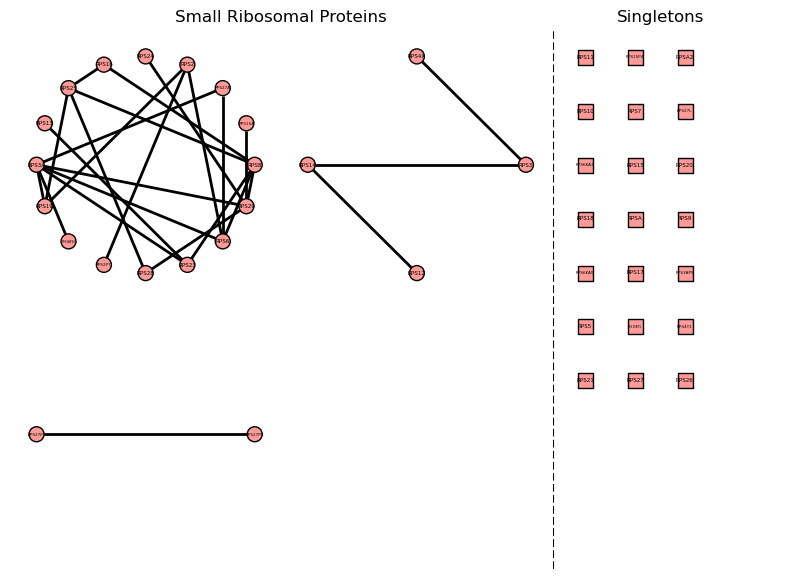

In [302]:
ribosomal_small = adata[adata.obs["external_gene_name"].str.startswith("RPS")]

fig, ax = plot_info(
    "Small Ribosomal Proteins",
    ribosomal_small,
    layout='circle',
    circsize=15
)
fig.savefig("out-figs/scrna-plots/gmgm-full/ribosomal_small.pdf", dpi=300, bbox_inches='tight')
pass

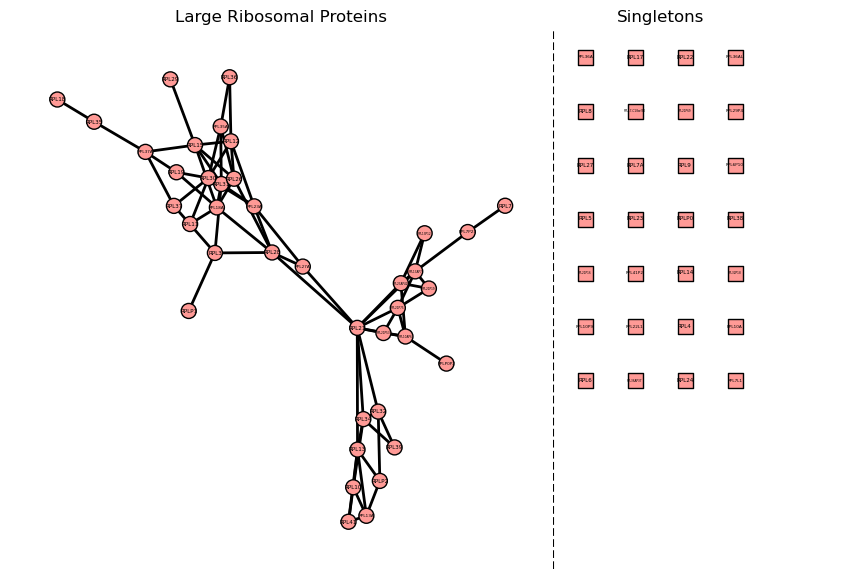

In [303]:
ribosomal_large = adata[adata.obs["external_gene_name"].str.startswith("RPL")]

fig, ax = plot_info(
    "Large Ribosomal Proteins",
    ribosomal_large,
    layout='fr'
)
fig.savefig("out-figs/scrna-plots/gmgm-full/ribosomal_large.pdf", dpi=300, bbox_inches='tight')
pass

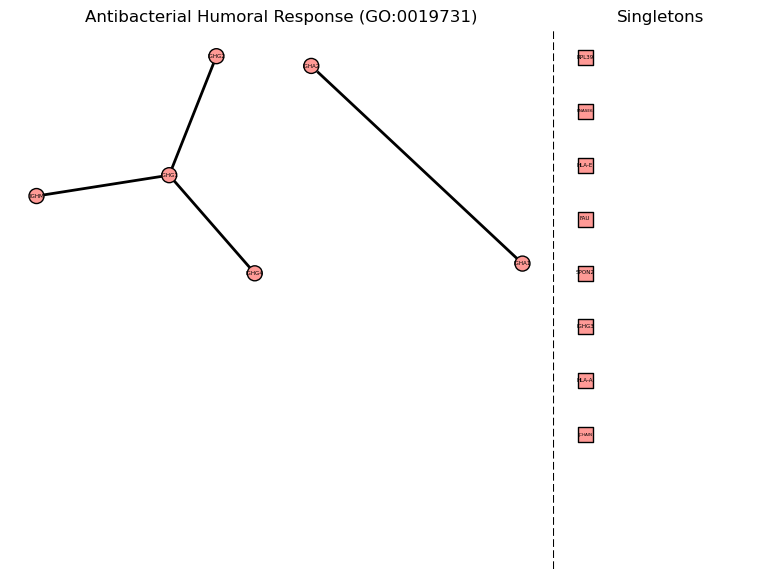

In [304]:
# antibacterial humoral response, GO:0019731

goid = [
    "HLA-A","SPRR2A","RNASE3","SEMG1","CAMP","DEFB1","BPIFA1","HLA-E","H2BC21",
    "PLA2G1B","RNASE7","DMBT1","WFDC11","WFDC9","RNASE4","WFDC10A","RNASE6","SEMG2","H2BC12L",
    "SLPI","ANG","SPON2","NOD2","H2BC11","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","TF","IGKV3-20","JCHAIN","ELANE","RPL39","FAU",
    "H2BC10","CTSG","MMP7","DEFA6","DEFA5","WFDC2","DEFA3","DEFA1","NCR3LG1","H2BC12",
    "LTF","PLA2G6","FGB","WFDC13","WFDC10B","WFDC3","PI3","LGALS4","WFDC5","DEFA4",
    "WFDC12",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Antibacterial Humoral Response (GO:0019731)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-full/antibacterial-humoral.pdf", dpi=300, bbox_inches='tight')
pass

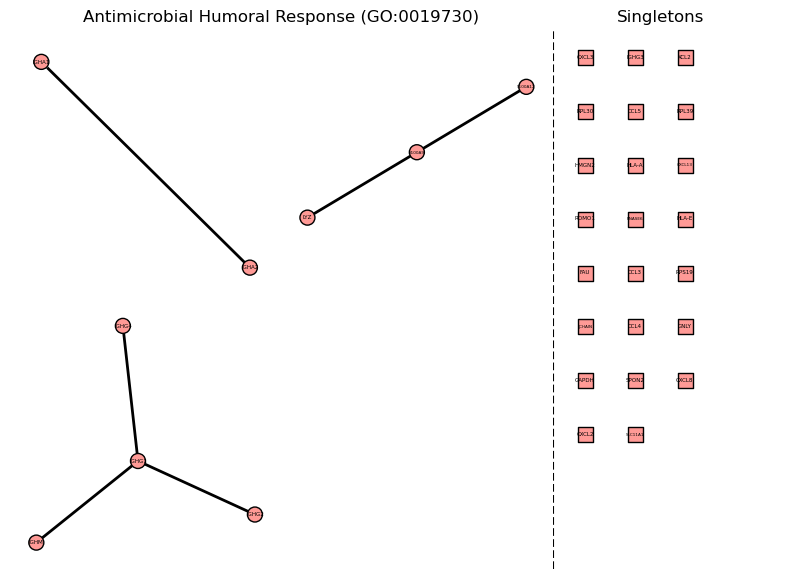

In [305]:
# antimicrobial humoral response, GO:0019730

goid = [
    "MUC7","CCL13","LYZ","HLA-A","GAPDH","CCL11","S100A7","REG3G","SPRR2A",
    "CCL18","CCL23","RNASE3","PRSS3","SEMG1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","BPIFA1","CCL15","CCL14","HLA-E","PGLYRP3","PGLYRP4","PGLYRP1",
    "CST9L","H2BC21","F2","DEFB4A","PLA2G1B","CCL4","CCL4L1","XCL1","CXCL8","CCL3",
    "BCL3","DEFB127","RNASE7","DMBT1","WFDC11","WFDC9","CXCL14","S100A12","ROMO1","RNASE4",
    "WFDC10A","RNASE6","PRSS2","CCL26","XCL2","GALP","AZU1","PF4V1","SEMG2","CCL5",
    "CCL2","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","ANG","SPON2","NOD2","TSLP",
    "CCL7","CCL8","H2BC11","CX3CL1","S100A9","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","PPBP","CXCL10","TF","CST9LP1","CST9","IGKV3-20",
    "CXCL9","JCHAIN","ELANE","CXCL13","RPS19","SLC11A1","RPL39","FAU","H2BC10","CCL1",
    "CXCL5","IL36RN","CTSG","CCL20","RPL30","REG1A","KRT6A","MMP7","DEFA6","DEFA5",
    "CXCL6","WFDC2","HMGN2","DEFA3","DEFA1","NCR3LG1","H2BC12","LTF","PF4","PLA2G6",
    "FGB","CCL21","WFDC13","WFDC10B","WFDC3","PI3","COLEC11","LGALS4","CXCL3","CXCL2",
    "SPAG11B","REG1B","CCL19","WFDC5","CCL17","GNLY","CXCL1","DEFA4","CCL22","WFDC12",
    "CCL3L1","RARRES2","SPAG11A","DEFB126","CCL24",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Antimicrobial Humoral Response (GO:0019730)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-full/antimicrobial-humoral.pdf", dpi=300, bbox_inches='tight')
pass

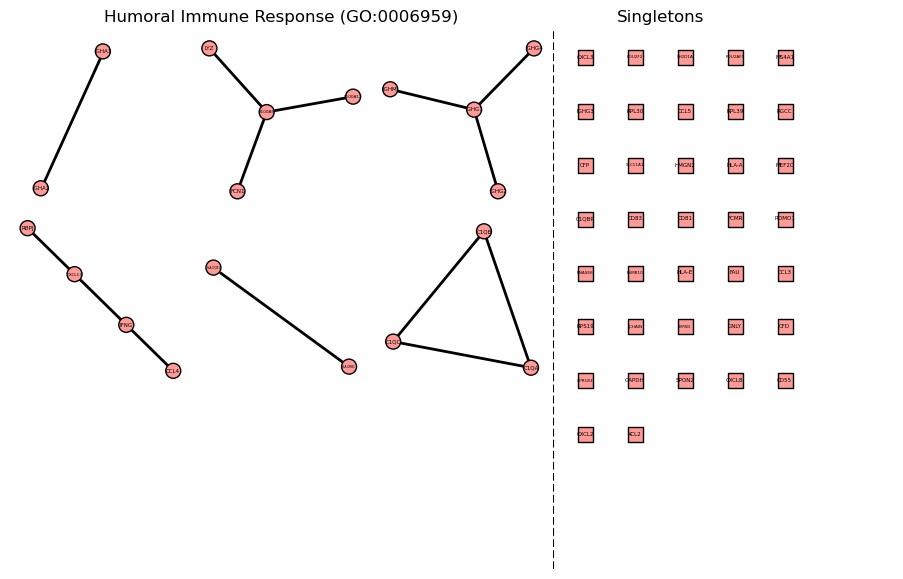

In [306]:
# humoral immune response, GO:0006959

goid = [
    "MUC7","POU2F2","CCL13","CCR2","BLNK","IFNE","LYZ","HLA-A","GAPDH",
    "CCL11","S100A7","REG3G","SPRR2A","CCL18","CCL23","BMI1","EBI3","RNASE3","CFP",
    "PRSS3","HLA-DQB1","CFH","SEMG1","KRT1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","CD81","BPIFA1","MEF2C","FCN3","CCL15","C8A","CCL14",
    "EXO1","HLA-E","PGLYRP3","PGLYRP4","RGCC","RBPJ","PGLYRP1","TNFRSF21","CST9L","H2BC21",
    "CFB","TREM1","CFD","C1R","F2","C1RL","TREM2","DEFB4A","PLA2G1B","C4BPA",
    "CCL4","CCL4L1","XCL1","CXCL8","COLEC10","YTHDF2","CCL3","BCL3","DEFB127","CD28",
    "RNASE7","C4BPB","C7","DMBT1","WFDC11","WFDC9","CXCL14","BCL2","IL7","S100A12",
    "CR1","ROMO1","RNASE4","C8B","C8G","CFHR3","WFDC10A","RNASE6","CLU","PRSS2",
    "POU2AF1","PSMB10","VSIG4","CCL26","XCL2","GALP","AZU1","PF4V1","C6","SEMG2",
    "CCL5","CCL2","GATA3","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","CR2","ANG",
    "SPON2","NOD2","CFHR1","TSLP","CCL7","CCL8","H2BC11","CX3CL1","GPI","S100A9",
    "FGA","IGHA2","IGHA1","IGHM","IGHG4","IGHG3","IGHG2","IGHG1","IGHE","C1QA",
    "C1QB","PPBP","CXCL10","TF","IFNK","CST9LP1","CST9","IGKV3-20","CXCL9","JCHAIN",
    "IFNG","IFNB1","IFNA17","IFNA14","IFNA5","IFNA21","IFNA7","IFNA10","IFNA2","IFNA1",
    "ELANE","CFI","SERPING1","IFNA16","IFNA4","IFNA6","IFNW1","IFNA8","CD83","CXCL13",
    "AIRE","RPS19","CD46","SLC11A1","GPR183","RPL39","FAU","H2BC10","C4B","CD55",
    "TNF","LTA","ALOX5","NOTCH1","C1QBP","CCL1","CXCL5","TRAF3IP2","IL36RN","SUSD4",
    "CTSG","CFHR2","CCL20","C4A","ST6GAL1","RPL30","REG1A","NOTCH2","C5","C3",
    "MBL2","KRT6A","MMP7","TFEB","DEFA6","DEFA5","SH2D1A","CXCL6","IL6","WFDC2",
    "HMGN2","DEFA3","DEFA1","PDCD1","MASP1","NCR3LG1","H2BC12","LTF","PF4","C9",
    "C1QC","PLA2G6","FGB","HLA-DRB1","CCL21","C2","CFHR4","WFDC13","WFDC10B","WFDC3",
    "FOXJ1","CFHR5","PI3","MS4A1","COLEC11","LGALS4","CXCL3","CXCL2","SPAG11B","REG1B",
    "CCL19","FCN2","WFDC5","CCL17","GNLY","CXCL1","FCMR","DEFA4","TFE3","CCR6",
    "CCL22","WFDC12","CCL3L1","FCN1","RARRES2","SPAG11A","DEFB126","C1S","BST1","ZP3",
    "MASP2","CCL24",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Humoral Immune Response (GO:0006959)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-full/humoral.pdf", dpi=300, bbox_inches='tight')
pass

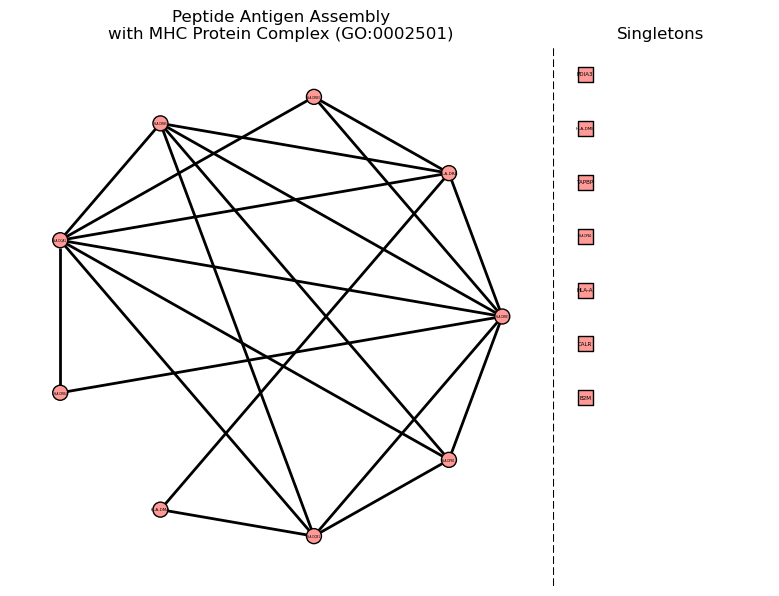

In [307]:
# peptide antigen assembly with MHC protein complex, GO:0002501

goid = [
    "HLA-DMA","HLA-DRA","B2M","HLA-DPB1","HLA-A","TAPBP","HLA-DRB5",
    "HLA-DQB1","HLA-DQA1","HLA-DQA2","HLA-DRA","CALR","PDIA3","HLA-DOB",
    "HLA-DRB4","HLA-DPA1","HLA-DRB3","HLA-DQB2","HLA-DOA","HLA-DRB1",
    "TAPBPL","HLA-DMB"
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex (GO:0002501)",
    goid_results,
    layout='circle',
    no_edge_weights=True,
    circsize=15
)
fig.savefig("out-figs/scrna-plots/gmgm-full/mhc.pdf", dpi=300, bbox_inches='tight')
pass

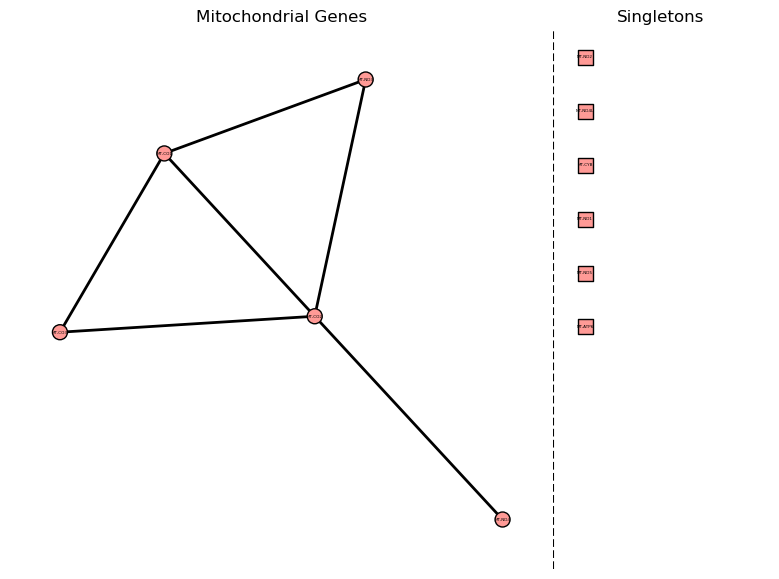

In [308]:
mito = adata[adata.obs["external_gene_name"].str.startswith("MT-")]

fig, ax = plot_info(
    "Mitochondrial Genes",
    mito,
    layout='fr'
)
fig.savefig("out-figs/scrna-plots/gmgm-full/mito.pdf", dpi=300, bbox_inches='tight')
pass

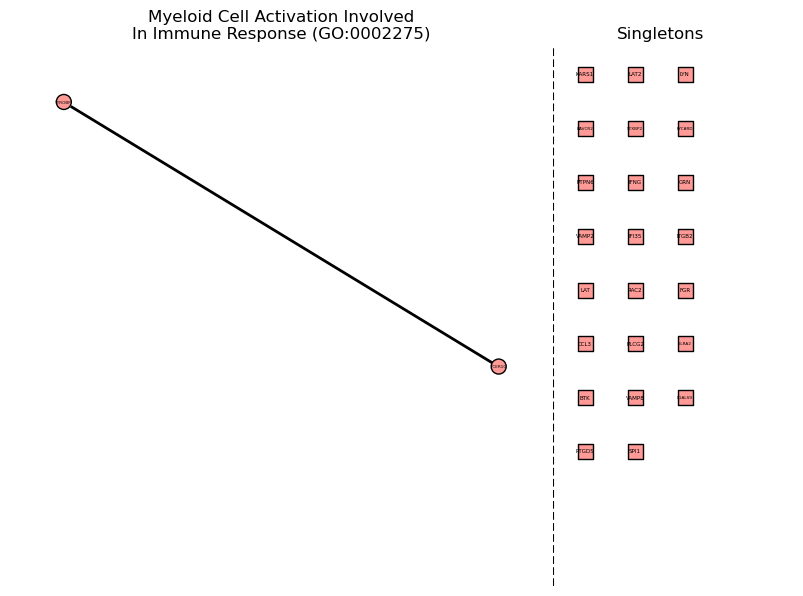

In [309]:
# Myeloid Cell Activation Involved In Immune Response, GO:0002275

goid = [
    "PTGDR", "LYN", "LBP", "CL2ORF4","SBNO2","SCNN1B","ITGB2","SYK",
    "IL13RA2","ADGRE2","VAMP7","IGHE","BCR","CHGA","PTAFR","PRKCE",
    "FOXF1","SLC18A2","CCL3","SNX4","STX4","PTGDS","SUCNR1","PYCARD",
    "CD177","GRP","LILRA2","RAC2","KARS1","IFI35","ITGAM","PLA2G3",
    "PDPK1","PRAM1","SPHK2","FES","LAT2","SCN11A","BTK",
    "GPR15LG","STXBP3","MILR1","TYROBP","ANXA3","RABGEF1","PTPN6",
    "NR4A3","GATA1","KIT","CLNK","FCER1G","RASGRP1","DNASE1","DNASE1L3",
    "SNAP23","RAB44","TREX1","CCR2","TNF","CD300A","NMI","IL4","LAT",
    "STXBP1","IL4R","PIK3CG","IL33","PLCG2","FGR","TICAM1","STXBP2",
    "MRGPRX2","ENPP3","LGALS9","GAB2","UNC13D","CX3CR1","TREM2",
    "S100A13","FCER1A","IL13","FER","CBL","F2RL1","SLAMF1","DOCK2","IFNG",
    "VAMP8","HAVCR2","CPLX2","ADORA2B","SPI1","GRN","GATA2","MYD88",
    "VAMP2","CD84","PIK3CD","DYSF"
]
ib_response = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Myeloid Cell Activation Involved\nIn Immune Response (GO:0002275)",
    ib_response,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-full/myeloid.pdf", dpi=300, bbox_inches='tight')
pass

In [310]:
goid_0019731 = [
    "HLA-A","SPRR2A","RNASE3","SEMG1","CAMP","DEFB1","BPIFA1","HLA-E","H2BC21",
    "PLA2G1B","RNASE7","DMBT1","WFDC11","WFDC9","RNASE4","WFDC10A","RNASE6","SEMG2","H2BC12L",
    "SLPI","ANG","SPON2","NOD2","H2BC11","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","TF","IGKV3-20","JCHAIN","ELANE","RPL39","FAU",
    "H2BC10","CTSG","MMP7","DEFA6","DEFA5","WFDC2","DEFA3","DEFA1","NCR3LG1","H2BC12",
    "LTF","PLA2G6","FGB","WFDC13","WFDC10B","WFDC3","PI3","LGALS4","WFDC5","DEFA4",
    "WFDC12",
]
goid_0006959 = [
    "MUC7","POU2F2","CCL13","CCR2","BLNK","IFNE","LYZ","HLA-A","GAPDH",
    "CCL11","S100A7","REG3G","SPRR2A","CCL18","CCL23","BMI1","EBI3","RNASE3","CFP",
    "PRSS3","HLA-DQB1","CFH","SEMG1","KRT1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","CD81","BPIFA1","MEF2C","FCN3","CCL15","C8A","CCL14",
    "EXO1","HLA-E","PGLYRP3","PGLYRP4","RGCC","RBPJ","PGLYRP1","TNFRSF21","CST9L","H2BC21",
    "CFB","TREM1","CFD","C1R","F2","C1RL","TREM2","DEFB4A","PLA2G1B","C4BPA",
    "CCL4","CCL4L1","XCL1","CXCL8","COLEC10","YTHDF2","CCL3","BCL3","DEFB127","CD28",
    "RNASE7","C4BPB","C7","DMBT1","WFDC11","WFDC9","CXCL14","BCL2","IL7","S100A12",
    "CR1","ROMO1","RNASE4","C8B","C8G","CFHR3","WFDC10A","RNASE6","CLU","PRSS2",
    "POU2AF1","PSMB10","VSIG4","CCL26","XCL2","GALP","AZU1","PF4V1","C6","SEMG2",
    "CCL5","CCL2","GATA3","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","CR2","ANG",
    "SPON2","NOD2","CFHR1","TSLP","CCL7","CCL8","H2BC11","CX3CL1","GPI","S100A9",
    "FGA","IGHA2","IGHA1","IGHM","IGHG4","IGHG3","IGHG2","IGHG1","IGHE","C1QA",
    "C1QB","PPBP","CXCL10","TF","IFNK","CST9LP1","CST9","IGKV3-20","CXCL9","JCHAIN",
    "IFNG","IFNB1","IFNA17","IFNA14","IFNA5","IFNA21","IFNA7","IFNA10","IFNA2","IFNA1",
    "ELANE","CFI","SERPING1","IFNA16","IFNA4","IFNA6","IFNW1","IFNA8","CD83","CXCL13",
    "AIRE","RPS19","CD46","SLC11A1","GPR183","RPL39","FAU","H2BC10","C4B","CD55",
    "TNF","LTA","ALOX5","NOTCH1","C1QBP","CCL1","CXCL5","TRAF3IP2","IL36RN","SUSD4",
    "CTSG","CFHR2","CCL20","C4A","ST6GAL1","RPL30","REG1A","NOTCH2","C5","C3",
    "MBL2","KRT6A","MMP7","TFEB","DEFA6","DEFA5","SH2D1A","CXCL6","IL6","WFDC2",
    "HMGN2","DEFA3","DEFA1","PDCD1","MASP1","NCR3LG1","H2BC12","LTF","PF4","C9",
    "C1QC","PLA2G6","FGB","HLA-DRB1","CCL21","C2","CFHR4","WFDC13","WFDC10B","WFDC3",
    "FOXJ1","CFHR5","PI3","MS4A1","COLEC11","LGALS4","CXCL3","CXCL2","SPAG11B","REG1B",
    "CCL19","FCN2","WFDC5","CCL17","GNLY","CXCL1","FCMR","DEFA4","TFE3","CCR6",
    "CCL22","WFDC12","CCL3L1","FCN1","RARRES2","SPAG11A","DEFB126","C1S","BST1","ZP3",
    "MASP2","CCL24",
]

goid_0002501 = [
    "HLA-DMA","HLA-DRA","B2M","HLA-DPB1","HLA-A","TAPBP","HLA-DRB5",
    "HLA-DQB1","HLA-DQA1","HLA-DQA2","HLA-DRA","CALR","PDIA3","HLA-DOB",
    "HLA-DRB4","HLA-DPA1","HLA-DRB3","HLA-DQB2","HLA-DOA","HLA-DRB1",
    "TAPBPL","HLA-DMB"
]

goid_0002275 = [
    "PTGDR", "LYN", "LBP", "CL2ORF4","SBNO2","SCNN1B","ITGB2","SYK",
    "IL13RA2","ADGRE2","VAMP7","IGHE","BCR","CHGA","PTAFR","PRKCE",
    "FOXF1","SLC18A2","CCL3","SNX4","STX4","PTGDS","SUCNR1","PYCARD",
    "CD177","GRP","LILRA2","RAC2","KARS1","IFI35","ITGAM","PLA2G3",
    "PDPK1","PRAM1","SPHK2","FES","LAT2","SCN11A","BTK",
    "GPR15LG","STXBP3","MILR1","TYROBP","ANXA3","RABGEF1","PTPN6",
    "NR4A3","GATA1","KIT","CLNK","FCER1G","RASGRP1","DNASE1","DNASE1L3",
    "SNAP23","RAB44","TREX1","CCR2","TNF","CD300A","NMI","IL4","LAT",
    "STXBP1","IL4R","PIK3CG","IL33","PLCG2","FGR","TICAM1","STXBP2",
    "MRGPRX2","ENPP3","LGALS9","GAB2","UNC13D","CX3CR1","TREM2",
    "S100A13","FCER1A","IL13","FER","CBL","F2RL1","SLAMF1","DOCK2","IFNG",
    "VAMP8","HAVCR2","CPLX2","ADORA2B","SPI1","GRN","GATA2","MYD88",
    "VAMP2","CD84","PIK3CD","DYSF"
]

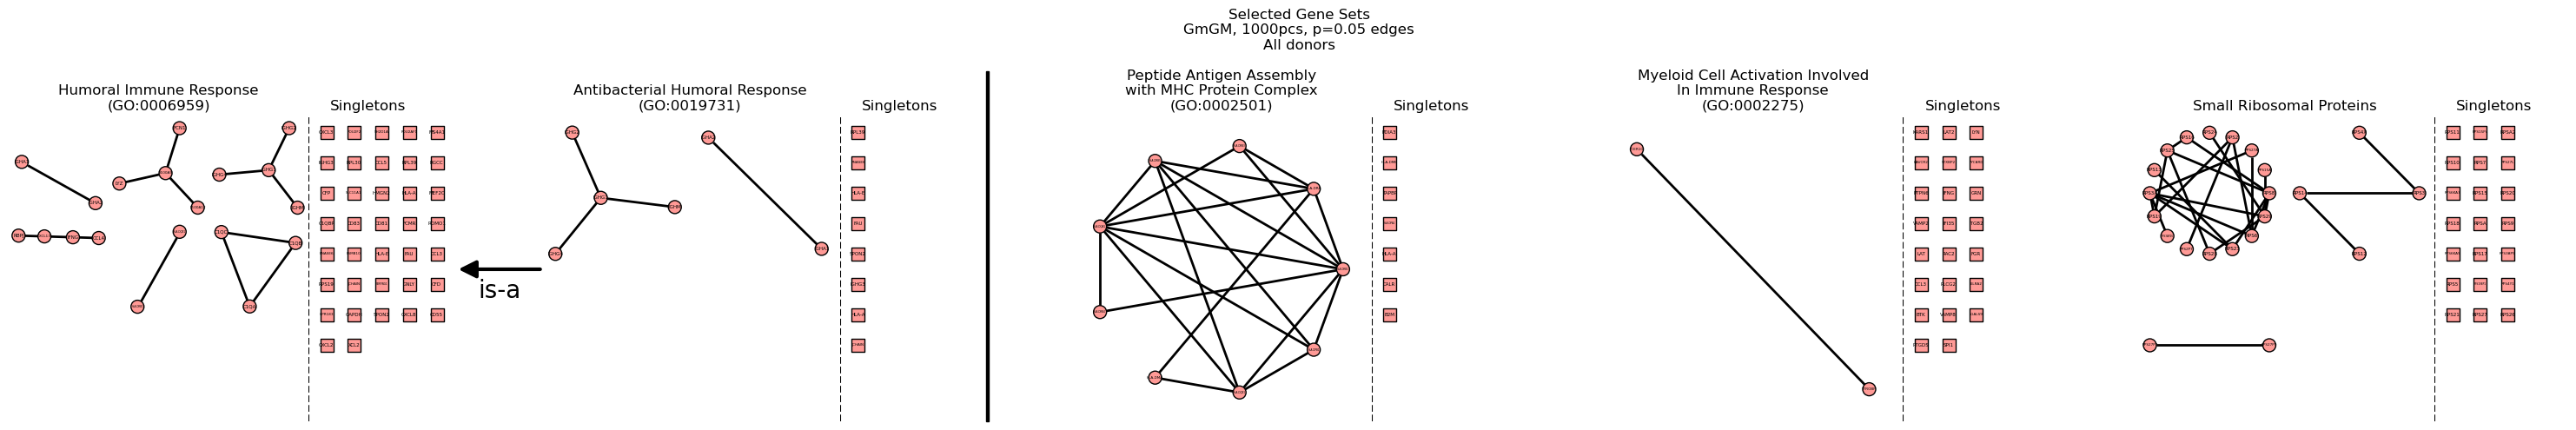

In [311]:
fig, axs = plt.subplots(figsize=(30, 5), nrows=1, ncols=5)

ribosomal_small = adata[adata.obs["external_gene_name"].str.startswith("RPS")]
plot_info(
    "Small Ribosomal Proteins",
    ribosomal_small,
    layout='circle',
    circsize=15,
    fig=fig,
    ax=axs[4]
)


goid_results = adata[adata.obs["external_gene_name"].isin(goid_0019731)]

plot_info(
    "Antibacterial Humoral Response\n(GO:0019731)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[1]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0006959)]

plot_info(
    "Humoral Immune Response\n(GO:0006959)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[0]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0002501)]

plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex\n(GO:0002501)",
    goid_results,
    layout='circle',
    no_edge_weights=True,
    circsize=15,
    fig=fig,
    ax=axs[2]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0002275)]

plot_info(
    "Myeloid Cell Activation Involved\nIn Immune Response\n(GO:0002275)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[3]
)

fig.suptitle(f"Selected Gene Sets\nGmGM, {PCS}pcs, p=0.05 edges\nAll donors")
fig.tight_layout()

# Draw is-a arrow
transFigure = fig.transFigure.inverted()
coord1 = transFigure.transform(axs[1].transData.transform([0, 0.5]))
coord2 = transFigure.transform(axs[0].transData.transform([1.5, 0.5]))
isa_arrow = patches.FancyArrowPatch(
    coord1,
    coord2,
    shrinkA=0,
    shrinkB=0,
    transform=fig.transFigure,
    color="black",
    arrowstyle="-|>",
    mutation_scale=30,
    linewidth=3,
)
fig.patches.append(isa_arrow)

# Add is-a label to it
isa_text = fig.text(
    0.5 * (coord1[0] + coord2[0]),
    0.5 * (coord1[1] + coord2[1]) - 0.05,
    "is-a",
    fontsize=20,
    ha='center',
    va='center',
    transform=fig.transFigure
)

# Add vertical bar between axs[1] and axs[2]
coord1 = transFigure.transform(axs[2].transData.transform([-0.2, 0]))
coord2 = transFigure.transform(axs[2].transData.transform([-0.2, 1.15]))
bar = patches.Rectangle(
    (coord1[0] - 0.01, coord1[1]),
    0.001,
    coord2[1] - coord1[1],
    transform=fig.transFigure,
    color="black"
)
fig.patches.append(bar)

fig.savefig("out-figs/scrna-plots/gmgm-full/selected-gene-sets-full.pdf", dpi=300)

pass

# GmGM Nonsignificant

In [312]:
adata = ad.read_h5ad(f"out/nonsignif-min-{MIN_EDGES}-pcs-{PCS}-E-GEOD-139324.h5ad", backed=True)
print((adata.obsp['gene'].data != 0).sum())
adata

21990


AnnData object with n_obs × n_vars = 2200 × 155970 backed at 'out/nonsignif-min-5-pcs-1000-E-GEOD-139324.h5ad'
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'
    obsp: 'gene'
    varp: 'cell'

In [313]:
x = adata.obsp['gene'] + adata.obsp['gene'].T
x.setdiag(0)
(x != 0).sum()

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


21990

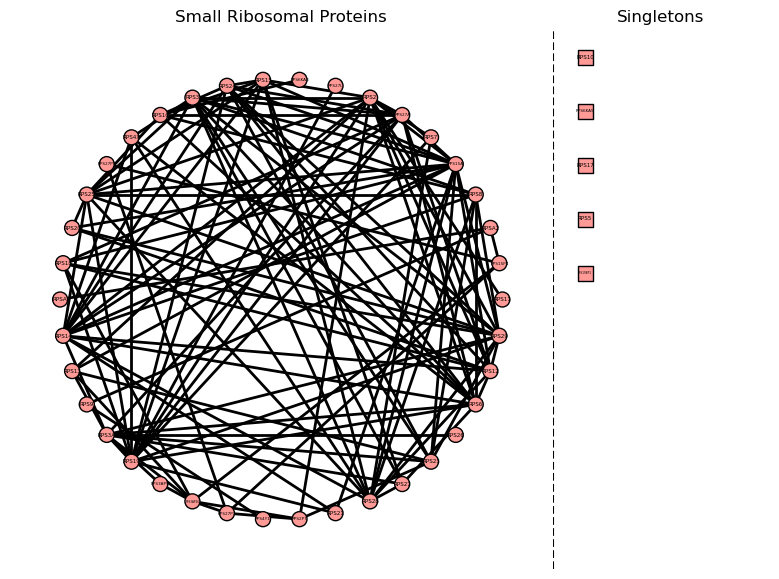

In [314]:
ribosomal_small = adata[adata.obs["external_gene_name"].str.startswith("RPS")]

fig, ax = plot_info(
    "Small Ribosomal Proteins",
    ribosomal_small,
    layout='circle',
    circsize=15
)
fig.savefig("out-figs/scrna-plots/gmgm-threshold/ribosomal_small.pdf", dpi=300, bbox_inches='tight')
pass

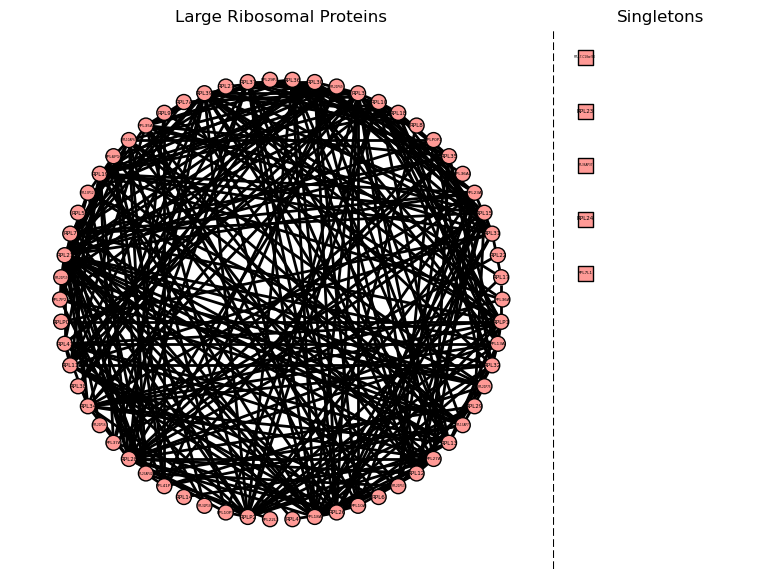

In [315]:
ribosomal_large = adata[adata.obs["external_gene_name"].str.startswith("RPL")]

fig, ax = plot_info(
    "Large Ribosomal Proteins",
    ribosomal_large,
    layout='circle'
)
fig.savefig("out-figs/scrna-plots/gmgm-threshold/ribosomal_large.pdf", dpi=300, bbox_inches='tight')
pass

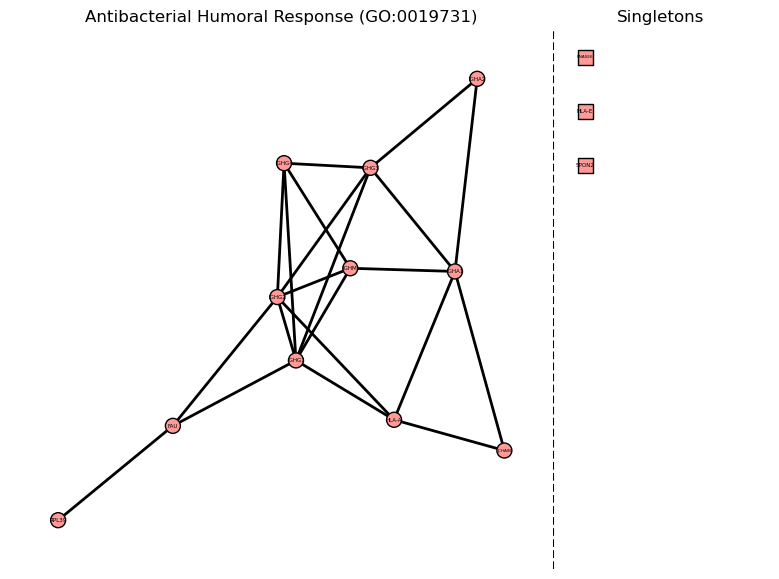

In [316]:
# antibacterial humoral response, GO:0019731

goid = [
    "HLA-A","SPRR2A","RNASE3","SEMG1","CAMP","DEFB1","BPIFA1","HLA-E","H2BC21",
    "PLA2G1B","RNASE7","DMBT1","WFDC11","WFDC9","RNASE4","WFDC10A","RNASE6","SEMG2","H2BC12L",
    "SLPI","ANG","SPON2","NOD2","H2BC11","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","TF","IGKV3-20","JCHAIN","ELANE","RPL39","FAU",
    "H2BC10","CTSG","MMP7","DEFA6","DEFA5","WFDC2","DEFA3","DEFA1","NCR3LG1","H2BC12",
    "LTF","PLA2G6","FGB","WFDC13","WFDC10B","WFDC3","PI3","LGALS4","WFDC5","DEFA4",
    "WFDC12",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Antibacterial Humoral Response (GO:0019731)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-threshold/antibacterial_humoral.pdf", dpi=300, bbox_inches='tight')
pass

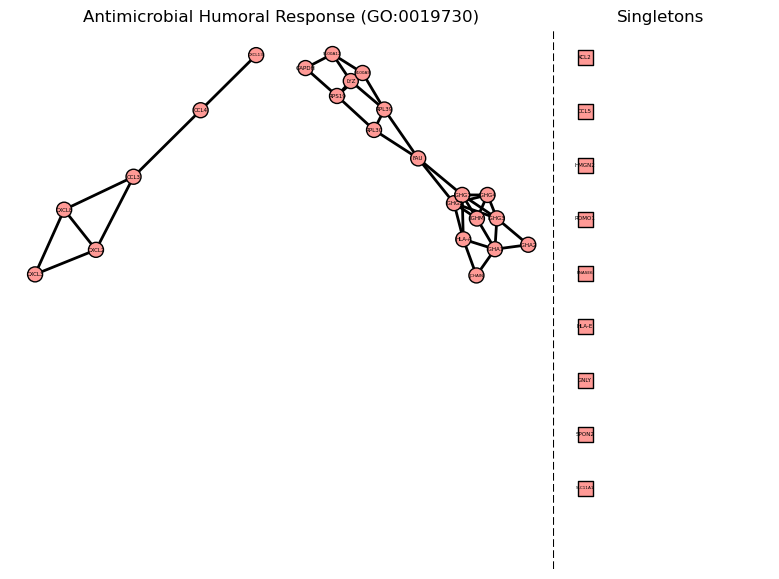

In [317]:
# antimicrobial humoral response, GO:0019730

goid = [
    "MUC7","CCL13","LYZ","HLA-A","GAPDH","CCL11","S100A7","REG3G","SPRR2A",
    "CCL18","CCL23","RNASE3","PRSS3","SEMG1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","BPIFA1","CCL15","CCL14","HLA-E","PGLYRP3","PGLYRP4","PGLYRP1",
    "CST9L","H2BC21","F2","DEFB4A","PLA2G1B","CCL4","CCL4L1","XCL1","CXCL8","CCL3",
    "BCL3","DEFB127","RNASE7","DMBT1","WFDC11","WFDC9","CXCL14","S100A12","ROMO1","RNASE4",
    "WFDC10A","RNASE6","PRSS2","CCL26","XCL2","GALP","AZU1","PF4V1","SEMG2","CCL5",
    "CCL2","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","ANG","SPON2","NOD2","TSLP",
    "CCL7","CCL8","H2BC11","CX3CL1","S100A9","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","PPBP","CXCL10","TF","CST9LP1","CST9","IGKV3-20",
    "CXCL9","JCHAIN","ELANE","CXCL13","RPS19","SLC11A1","RPL39","FAU","H2BC10","CCL1",
    "CXCL5","IL36RN","CTSG","CCL20","RPL30","REG1A","KRT6A","MMP7","DEFA6","DEFA5",
    "CXCL6","WFDC2","HMGN2","DEFA3","DEFA1","NCR3LG1","H2BC12","LTF","PF4","PLA2G6",
    "FGB","CCL21","WFDC13","WFDC10B","WFDC3","PI3","COLEC11","LGALS4","CXCL3","CXCL2",
    "SPAG11B","REG1B","CCL19","WFDC5","CCL17","GNLY","CXCL1","DEFA4","CCL22","WFDC12",
    "CCL3L1","RARRES2","SPAG11A","DEFB126","CCL24",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Antimicrobial Humoral Response (GO:0019730)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-threshold/antimicrobial_humoral.pdf", dpi=300, bbox_inches='tight')
pass

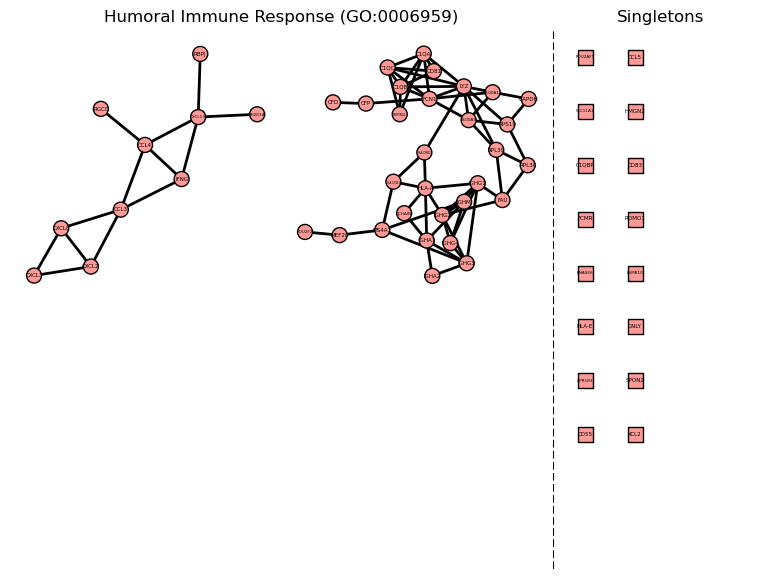

In [318]:
# humoral immune response, GO:0006959

goid = [
    "MUC7","POU2F2","CCL13","CCR2","BLNK","IFNE","LYZ","HLA-A","GAPDH",
    "CCL11","S100A7","REG3G","SPRR2A","CCL18","CCL23","BMI1","EBI3","RNASE3","CFP",
    "PRSS3","HLA-DQB1","CFH","SEMG1","KRT1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","CD81","BPIFA1","MEF2C","FCN3","CCL15","C8A","CCL14",
    "EXO1","HLA-E","PGLYRP3","PGLYRP4","RGCC","RBPJ","PGLYRP1","TNFRSF21","CST9L","H2BC21",
    "CFB","TREM1","CFD","C1R","F2","C1RL","TREM2","DEFB4A","PLA2G1B","C4BPA",
    "CCL4","CCL4L1","XCL1","CXCL8","COLEC10","YTHDF2","CCL3","BCL3","DEFB127","CD28",
    "RNASE7","C4BPB","C7","DMBT1","WFDC11","WFDC9","CXCL14","BCL2","IL7","S100A12",
    "CR1","ROMO1","RNASE4","C8B","C8G","CFHR3","WFDC10A","RNASE6","CLU","PRSS2",
    "POU2AF1","PSMB10","VSIG4","CCL26","XCL2","GALP","AZU1","PF4V1","C6","SEMG2",
    "CCL5","CCL2","GATA3","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","CR2","ANG",
    "SPON2","NOD2","CFHR1","TSLP","CCL7","CCL8","H2BC11","CX3CL1","GPI","S100A9",
    "FGA","IGHA2","IGHA1","IGHM","IGHG4","IGHG3","IGHG2","IGHG1","IGHE","C1QA",
    "C1QB","PPBP","CXCL10","TF","IFNK","CST9LP1","CST9","IGKV3-20","CXCL9","JCHAIN",
    "IFNG","IFNB1","IFNA17","IFNA14","IFNA5","IFNA21","IFNA7","IFNA10","IFNA2","IFNA1",
    "ELANE","CFI","SERPING1","IFNA16","IFNA4","IFNA6","IFNW1","IFNA8","CD83","CXCL13",
    "AIRE","RPS19","CD46","SLC11A1","GPR183","RPL39","FAU","H2BC10","C4B","CD55",
    "TNF","LTA","ALOX5","NOTCH1","C1QBP","CCL1","CXCL5","TRAF3IP2","IL36RN","SUSD4",
    "CTSG","CFHR2","CCL20","C4A","ST6GAL1","RPL30","REG1A","NOTCH2","C5","C3",
    "MBL2","KRT6A","MMP7","TFEB","DEFA6","DEFA5","SH2D1A","CXCL6","IL6","WFDC2",
    "HMGN2","DEFA3","DEFA1","PDCD1","MASP1","NCR3LG1","H2BC12","LTF","PF4","C9",
    "C1QC","PLA2G6","FGB","HLA-DRB1","CCL21","C2","CFHR4","WFDC13","WFDC10B","WFDC3",
    "FOXJ1","CFHR5","PI3","MS4A1","COLEC11","LGALS4","CXCL3","CXCL2","SPAG11B","REG1B",
    "CCL19","FCN2","WFDC5","CCL17","GNLY","CXCL1","FCMR","DEFA4","TFE3","CCR6",
    "CCL22","WFDC12","CCL3L1","FCN1","RARRES2","SPAG11A","DEFB126","C1S","BST1","ZP3",
    "MASP2","CCL24",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Humoral Immune Response (GO:0006959)",
    goid_results,
    layout='dh',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-threshold/humoral.pdf", dpi=300, bbox_inches='tight')
pass

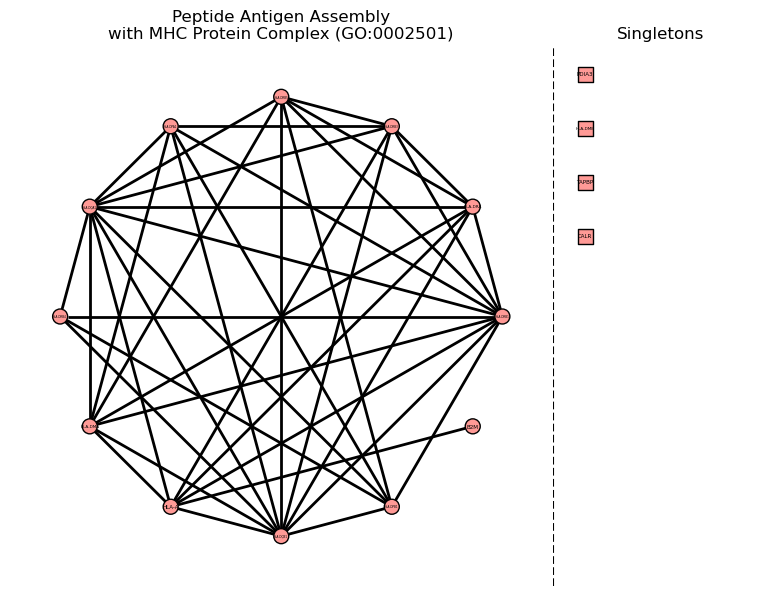

In [319]:
# peptide antigen assembly with MHC protein complex, GO:0002501

goid = [
    "HLA-DMA","HLA-DRA","B2M","HLA-DPB1","HLA-A","TAPBP","HLA-DRB5",
    "HLA-DQB1","HLA-DQA1","HLA-DQA2","HLA-DRA","CALR","PDIA3","HLA-DOB",
    "HLA-DRB4","HLA-DPA1","HLA-DRB3","HLA-DQB2","HLA-DOA","HLA-DRB1",
    "TAPBPL","HLA-DMB"
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex (GO:0002501)",
    goid_results,
    layout='circle',
    no_edge_weights=True,
    circsize=15
)
fig.savefig("out-figs/scrna-plots/gmgm-threshold/mhc.pdf", dpi=300, bbox_inches='tight')
pass

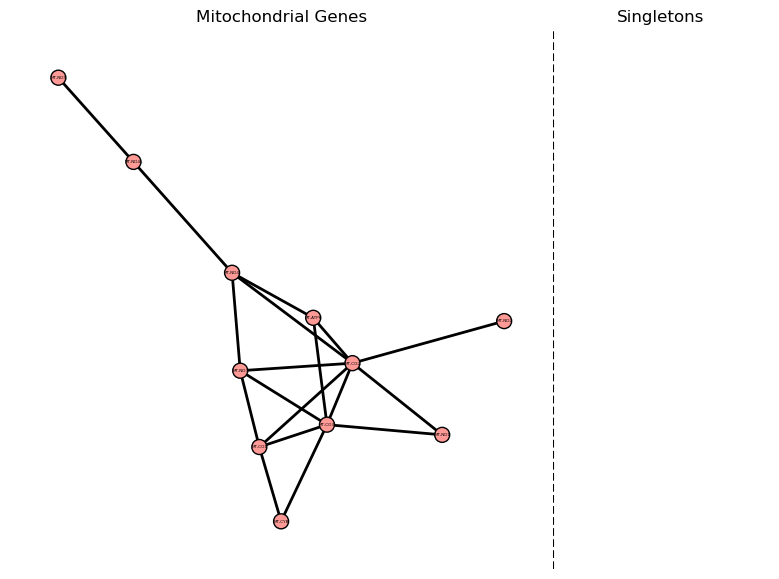

In [320]:
mito = adata[adata.obs["external_gene_name"].str.startswith("MT-")]

fig, ax = plot_info(
    "Mitochondrial Genes",
    mito,
    layout='fr'
)
fig.savefig("out-figs/scrna-plots/gmgm-threshold/mito.pdf", dpi=300, bbox_inches='tight')
pass

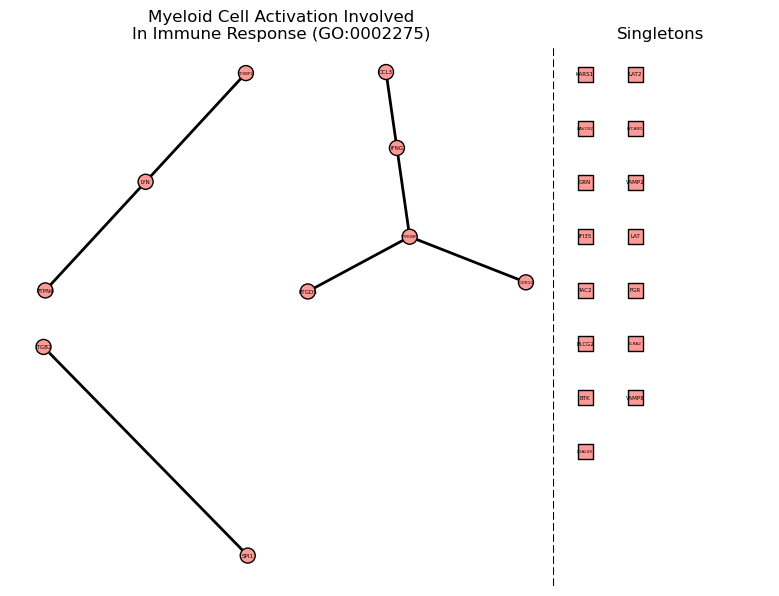

In [321]:
# Myeloid Cell Activation Involved In Immune Response, GO:0002275

goid = [
    "PTGDR", "LYN", "LBP", "CL2ORF4","SBNO2","SCNN1B","ITGB2","SYK",
    "IL13RA2","ADGRE2","VAMP7","IGHE","BCR","CHGA","PTAFR","PRKCE",
    "FOXF1","SLC18A2","CCL3","SNX4","STX4","PTGDS","SUCNR1","PYCARD",
    "CD177","GRP","LILRA2","RAC2","KARS1","IFI35","ITGAM","PLA2G3",
    "PDPK1","PRAM1","SPHK2","FES","LAT2","SCN11A","BTK",
    "GPR15LG","STXBP3","MILR1","TYROBP","ANXA3","RABGEF1","PTPN6",
    "NR4A3","GATA1","KIT","CLNK","FCER1G","RASGRP1","DNASE1","DNASE1L3",
    "SNAP23","RAB44","TREX1","CCR2","TNF","CD300A","NMI","IL4","LAT",
    "STXBP1","IL4R","PIK3CG","IL33","PLCG2","FGR","TICAM1","STXBP2",
    "MRGPRX2","ENPP3","LGALS9","GAB2","UNC13D","CX3CR1","TREM2",
    "S100A13","FCER1A","IL13","FER","CBL","F2RL1","SLAMF1","DOCK2","IFNG",
    "VAMP8","HAVCR2","CPLX2","ADORA2B","SPI1","GRN","GATA2","MYD88",
    "VAMP2","CD84","PIK3CD","DYSF"
]
ib_response = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Myeloid Cell Activation Involved\nIn Immune Response (GO:0002275)",
    ib_response,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-threshold/myeloid.pdf", dpi=300, bbox_inches='tight')
pass

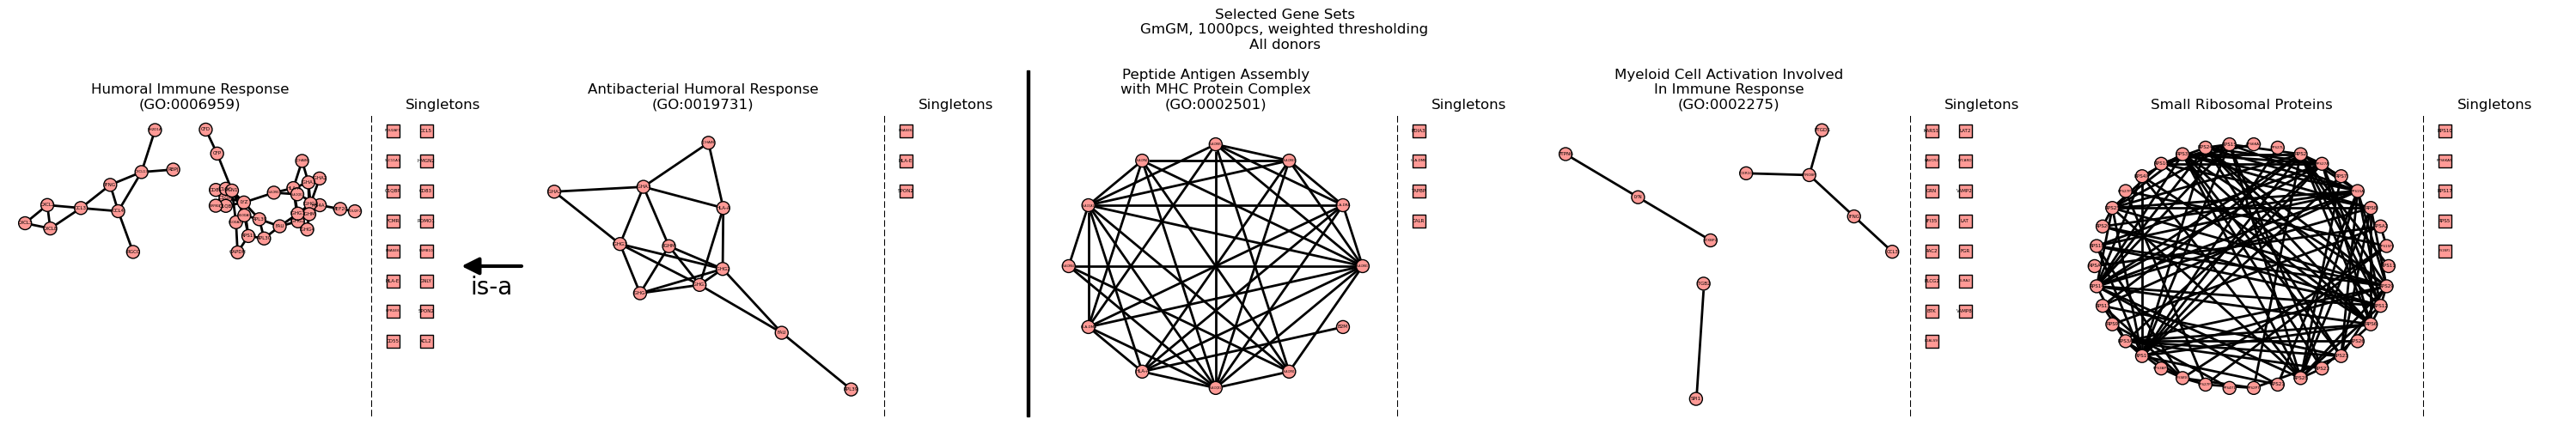

In [322]:
fig, axs = plt.subplots(figsize=(30, 5), nrows=1, ncols=5)

ribosomal_small = adata[adata.obs["external_gene_name"].str.startswith("RPS")]
plot_info(
    "Small Ribosomal Proteins",
    ribosomal_small,
    layout='circle',
    circsize=15,
    fig=fig,
    ax=axs[4]
)


goid_results = adata[adata.obs["external_gene_name"].isin(goid_0019731)]

plot_info(
    "Antibacterial Humoral Response\n(GO:0019731)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[1]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0006959)]

plot_info(
    "Humoral Immune Response\n(GO:0006959)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[0]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0002501)]

plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex\n(GO:0002501)",
    goid_results,
    layout='circle',
    no_edge_weights=True,
    circsize=15,
    fig=fig,
    ax=axs[2]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0002275)]

plot_info(
    "Myeloid Cell Activation Involved\nIn Immune Response\n(GO:0002275)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[3]
)

fig.suptitle(f"Selected Gene Sets\nGmGM, {PCS}pcs, weighted thresholding\nAll donors")
fig.tight_layout()

# Draw is-a arrow
transFigure = fig.transFigure.inverted()
coord1 = transFigure.transform(axs[1].transData.transform([0, 0.5]))
coord2 = transFigure.transform(axs[0].transData.transform([1.25, 0.5]))
isa_arrow = patches.FancyArrowPatch(
    coord1,
    coord2,
    shrinkA=0,
    shrinkB=0,
    transform=fig.transFigure,
    color="black",
    arrowstyle="-|>",
    mutation_scale=30,
    linewidth=3,
)
fig.patches.append(isa_arrow)

# Add is-a label to it
isa_text = fig.text(
    0.5 * (coord1[0] + coord2[0]),
    0.5 * (coord1[1] + coord2[1]) - 0.05,
    "is-a",
    fontsize=20,
    ha='center',
    va='center',
    transform=fig.transFigure
)

# Add vertical bar between axs[1] and axs[2]
coord1 = transFigure.transform(axs[2].transData.transform([0.05, 0]))
coord2 = transFigure.transform(axs[2].transData.transform([0.05, 1.15]))
bar = patches.Rectangle(
    (coord1[0] - 0.01, coord1[1]),
    0.001,
    coord2[1] - coord1[1],
    transform=fig.transFigure,
    color="black"
)
fig.patches.append(bar)

fig.savefig("out-figs/scrna-plots/gmgm-threshold/selected-gene-sets-threshold.pdf", dpi=300, bbox_inches='tight')

pass

# GmGM, Small, Nonsignificant

In [323]:
adata = ad.read_h5ad(f"out/small-min-{MIN_EDGES}-pcs-{PCS}-E-GEOD-139324.h5ad", backed=True)
print((adata.obsp['gene'].data != 0).sum())
adata

21890


AnnData object with n_obs × n_vars = 2190 × 1466 backed at 'out/small-min-5-pcs-1000-E-GEOD-139324.h5ad'
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'
    obsp: 'gene'
    varp: 'cell'

In [324]:
x = adata.obsp['gene'] + adata.obsp['gene'].T
x.setdiag(0)
(x != 0).sum()

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


21890

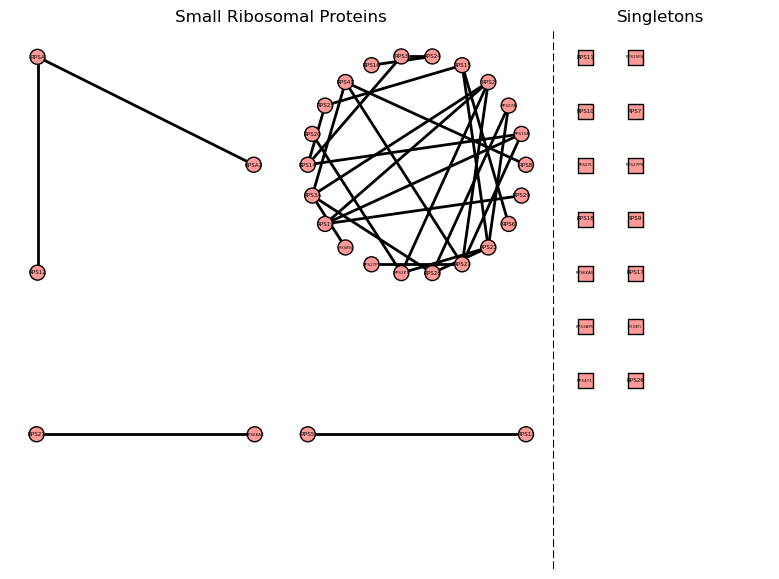

In [325]:
ribosomal_small = adata[adata.obs["external_gene_name"].str.startswith("RPS")]

fig, ax = plot_info(
    "Small Ribosomal Proteins",
    ribosomal_small,
    layout='circle',
    circsize=15
)
fig.savefig("out-figs/scrna-plots/gmgm-small/ribosomal_small.pdf", dpi=300, bbox_inches='tight')
pass

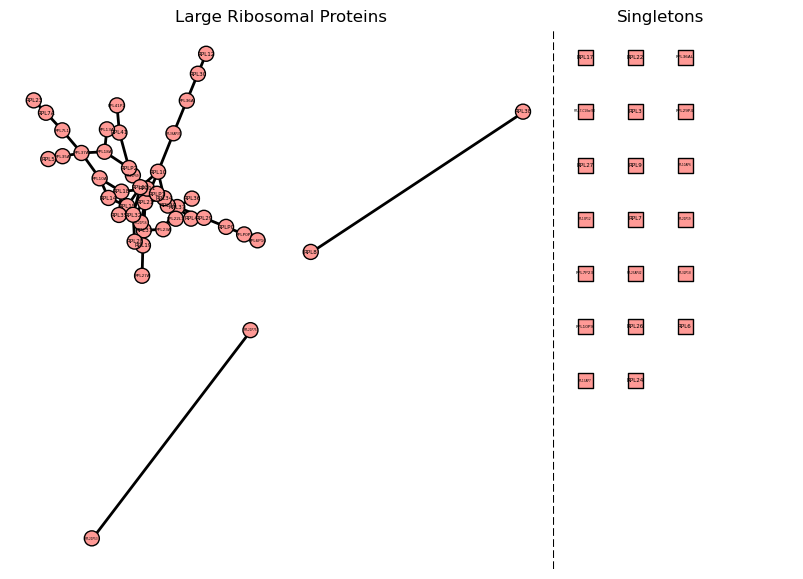

In [326]:
ribosomal_large = adata[adata.obs["external_gene_name"].str.startswith("RPL")]

fig, ax = plot_info(
    "Large Ribosomal Proteins",
    ribosomal_large,
    layout='fr'
)
fig.savefig("out-figs/scrna-plots/gmgm-small/ribosomal_large.pdf", dpi=300, bbox_inches='tight')
pass

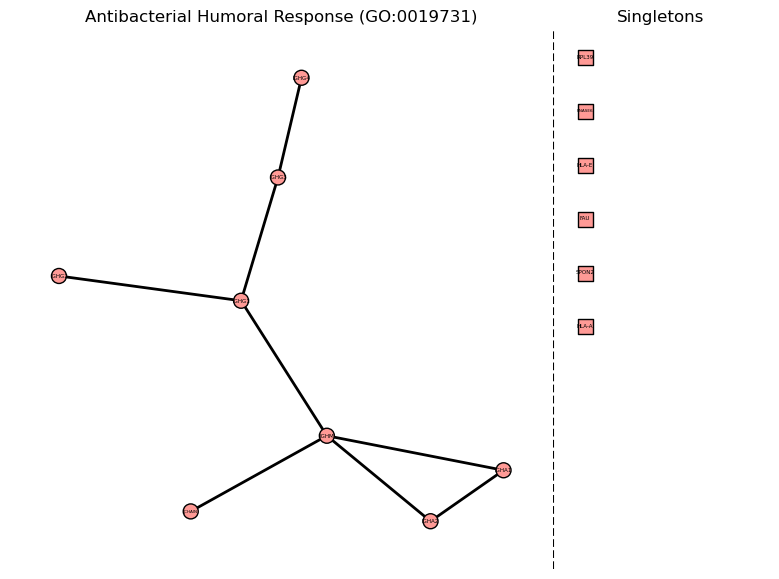

In [327]:
# antibacterial humoral response, GO:0019731

goid = [
    "HLA-A","SPRR2A","RNASE3","SEMG1","CAMP","DEFB1","BPIFA1","HLA-E","H2BC21",
    "PLA2G1B","RNASE7","DMBT1","WFDC11","WFDC9","RNASE4","WFDC10A","RNASE6","SEMG2","H2BC12L",
    "SLPI","ANG","SPON2","NOD2","H2BC11","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","TF","IGKV3-20","JCHAIN","ELANE","RPL39","FAU",
    "H2BC10","CTSG","MMP7","DEFA6","DEFA5","WFDC2","DEFA3","DEFA1","NCR3LG1","H2BC12",
    "LTF","PLA2G6","FGB","WFDC13","WFDC10B","WFDC3","PI3","LGALS4","WFDC5","DEFA4",
    "WFDC12",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Antibacterial Humoral Response (GO:0019731)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-small/antibacterial_humoral.pdf", dpi=300, bbox_inches='tight')
pass

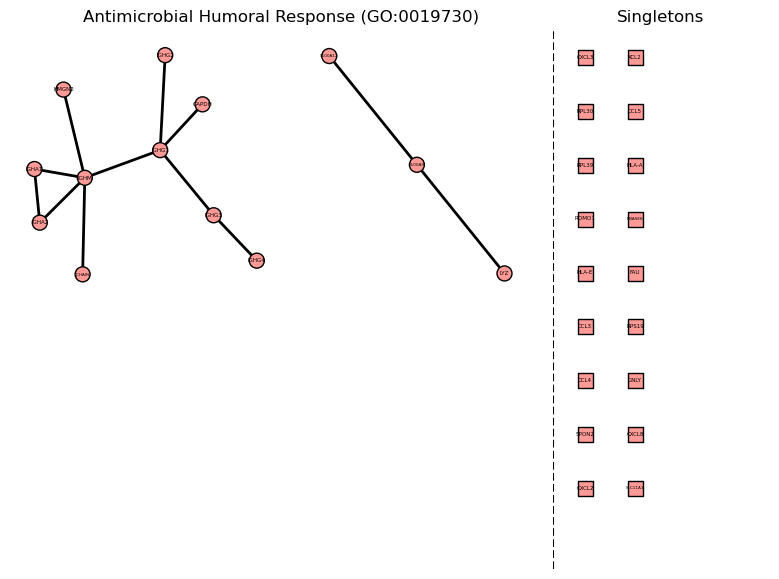

In [328]:
# antimicrobial humoral response, GO:0019730

goid = [
    "MUC7","CCL13","LYZ","HLA-A","GAPDH","CCL11","S100A7","REG3G","SPRR2A",
    "CCL18","CCL23","RNASE3","PRSS3","SEMG1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","BPIFA1","CCL15","CCL14","HLA-E","PGLYRP3","PGLYRP4","PGLYRP1",
    "CST9L","H2BC21","F2","DEFB4A","PLA2G1B","CCL4","CCL4L1","XCL1","CXCL8","CCL3",
    "BCL3","DEFB127","RNASE7","DMBT1","WFDC11","WFDC9","CXCL14","S100A12","ROMO1","RNASE4",
    "WFDC10A","RNASE6","PRSS2","CCL26","XCL2","GALP","AZU1","PF4V1","SEMG2","CCL5",
    "CCL2","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","ANG","SPON2","NOD2","TSLP",
    "CCL7","CCL8","H2BC11","CX3CL1","S100A9","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","PPBP","CXCL10","TF","CST9LP1","CST9","IGKV3-20",
    "CXCL9","JCHAIN","ELANE","CXCL13","RPS19","SLC11A1","RPL39","FAU","H2BC10","CCL1",
    "CXCL5","IL36RN","CTSG","CCL20","RPL30","REG1A","KRT6A","MMP7","DEFA6","DEFA5",
    "CXCL6","WFDC2","HMGN2","DEFA3","DEFA1","NCR3LG1","H2BC12","LTF","PF4","PLA2G6",
    "FGB","CCL21","WFDC13","WFDC10B","WFDC3","PI3","COLEC11","LGALS4","CXCL3","CXCL2",
    "SPAG11B","REG1B","CCL19","WFDC5","CCL17","GNLY","CXCL1","DEFA4","CCL22","WFDC12",
    "CCL3L1","RARRES2","SPAG11A","DEFB126","CCL24",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Antimicrobial Humoral Response (GO:0019730)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-small/antimicrobial_humoral.pdf", dpi=300, bbox_inches='tight')
pass

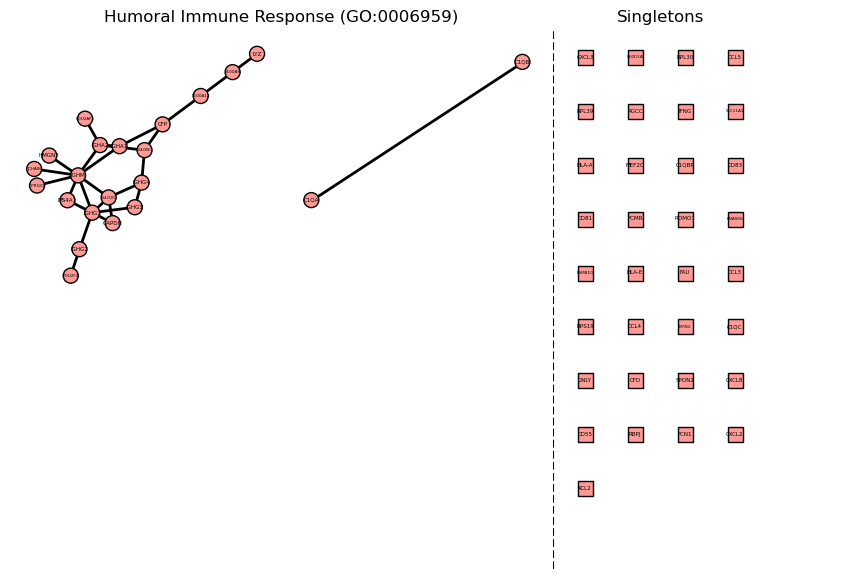

In [329]:
# humoral immune response, GO:0006959

goid = [
    "MUC7","POU2F2","CCL13","CCR2","BLNK","IFNE","LYZ","HLA-A","GAPDH",
    "CCL11","S100A7","REG3G","SPRR2A","CCL18","CCL23","BMI1","EBI3","RNASE3","CFP",
    "PRSS3","HLA-DQB1","CFH","SEMG1","KRT1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","CD81","BPIFA1","MEF2C","FCN3","CCL15","C8A","CCL14",
    "EXO1","HLA-E","PGLYRP3","PGLYRP4","RGCC","RBPJ","PGLYRP1","TNFRSF21","CST9L","H2BC21",
    "CFB","TREM1","CFD","C1R","F2","C1RL","TREM2","DEFB4A","PLA2G1B","C4BPA",
    "CCL4","CCL4L1","XCL1","CXCL8","COLEC10","YTHDF2","CCL3","BCL3","DEFB127","CD28",
    "RNASE7","C4BPB","C7","DMBT1","WFDC11","WFDC9","CXCL14","BCL2","IL7","S100A12",
    "CR1","ROMO1","RNASE4","C8B","C8G","CFHR3","WFDC10A","RNASE6","CLU","PRSS2",
    "POU2AF1","PSMB10","VSIG4","CCL26","XCL2","GALP","AZU1","PF4V1","C6","SEMG2",
    "CCL5","CCL2","GATA3","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","CR2","ANG",
    "SPON2","NOD2","CFHR1","TSLP","CCL7","CCL8","H2BC11","CX3CL1","GPI","S100A9",
    "FGA","IGHA2","IGHA1","IGHM","IGHG4","IGHG3","IGHG2","IGHG1","IGHE","C1QA",
    "C1QB","PPBP","CXCL10","TF","IFNK","CST9LP1","CST9","IGKV3-20","CXCL9","JCHAIN",
    "IFNG","IFNB1","IFNA17","IFNA14","IFNA5","IFNA21","IFNA7","IFNA10","IFNA2","IFNA1",
    "ELANE","CFI","SERPING1","IFNA16","IFNA4","IFNA6","IFNW1","IFNA8","CD83","CXCL13",
    "AIRE","RPS19","CD46","SLC11A1","GPR183","RPL39","FAU","H2BC10","C4B","CD55",
    "TNF","LTA","ALOX5","NOTCH1","C1QBP","CCL1","CXCL5","TRAF3IP2","IL36RN","SUSD4",
    "CTSG","CFHR2","CCL20","C4A","ST6GAL1","RPL30","REG1A","NOTCH2","C5","C3",
    "MBL2","KRT6A","MMP7","TFEB","DEFA6","DEFA5","SH2D1A","CXCL6","IL6","WFDC2",
    "HMGN2","DEFA3","DEFA1","PDCD1","MASP1","NCR3LG1","H2BC12","LTF","PF4","C9",
    "C1QC","PLA2G6","FGB","HLA-DRB1","CCL21","C2","CFHR4","WFDC13","WFDC10B","WFDC3",
    "FOXJ1","CFHR5","PI3","MS4A1","COLEC11","LGALS4","CXCL3","CXCL2","SPAG11B","REG1B",
    "CCL19","FCN2","WFDC5","CCL17","GNLY","CXCL1","FCMR","DEFA4","TFE3","CCR6",
    "CCL22","WFDC12","CCL3L1","FCN1","RARRES2","SPAG11A","DEFB126","C1S","BST1","ZP3",
    "MASP2","CCL24",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Humoral Immune Response (GO:0006959)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-small/humoral.pdf", dpi=300, bbox_inches='tight')
pass

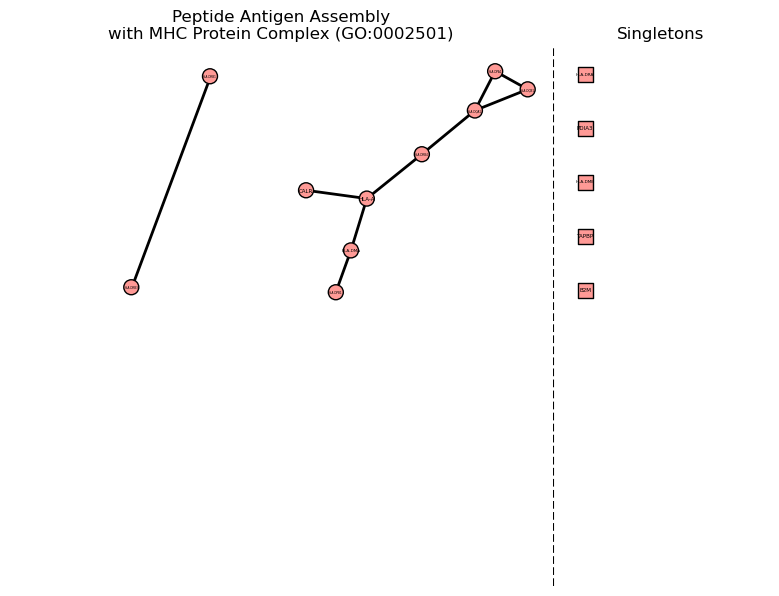

In [330]:
# peptide antigen assembly with MHC protein complex, GO:0002501

goid = [
    "HLA-DMA","HLA-DRA","B2M","HLA-DPB1","HLA-A","TAPBP","HLA-DRB5",
    "HLA-DQB1","HLA-DQA1","HLA-DQA2","HLA-DRA","CALR","PDIA3","HLA-DOB",
    "HLA-DRB4","HLA-DPA1","HLA-DRB3","HLA-DQB2","HLA-DOA","HLA-DRB1",
    "TAPBPL","HLA-DMB"
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex (GO:0002501)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    circsize=15
)
fig.savefig("out-figs/scrna-plots/gmgm-small/mhc.pdf", dpi=300, bbox_inches='tight')
pass

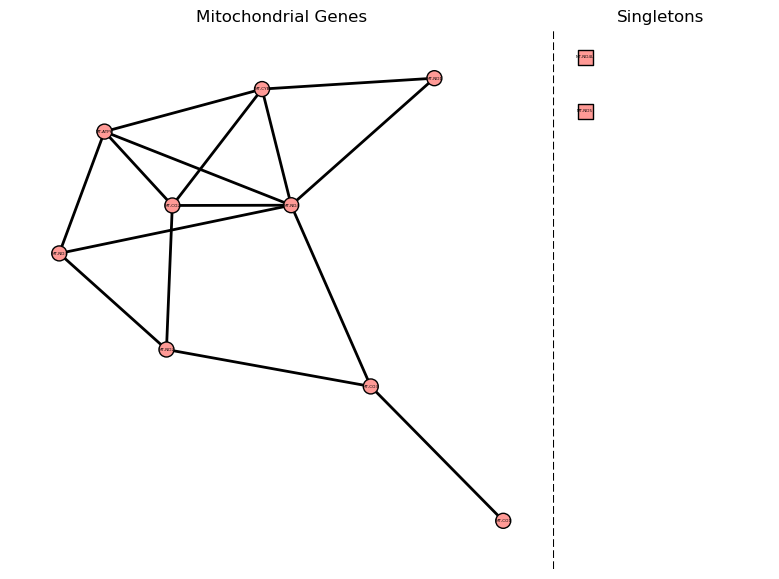

In [331]:
mito = adata[adata.obs["external_gene_name"].str.startswith("MT-")]

fig, ax = plot_info(
    "Mitochondrial Genes",
    mito,
    layout='fr'
)
fig.savefig("out-figs/scrna-plots/gmgm-small/mito.pdf", dpi=300, bbox_inches='tight')
pass

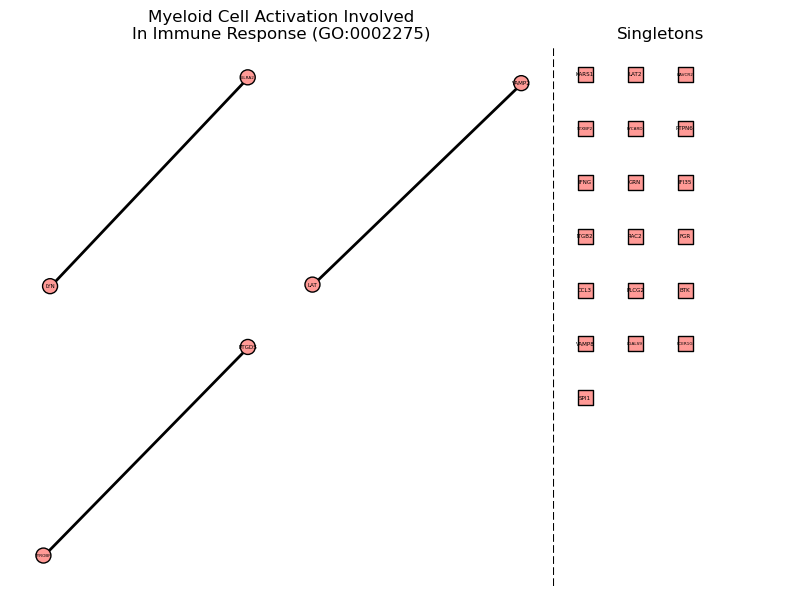

In [332]:
# Myeloid Cell Activation Involved In Immune Response, GO:0002275

goid = [
    "PTGDR", "LYN", "LBP", "CL2ORF4","SBNO2","SCNN1B","ITGB2","SYK",
    "IL13RA2","ADGRE2","VAMP7","IGHE","BCR","CHGA","PTAFR","PRKCE",
    "FOXF1","SLC18A2","CCL3","SNX4","STX4","PTGDS","SUCNR1","PYCARD",
    "CD177","GRP","LILRA2","RAC2","KARS1","IFI35","ITGAM","PLA2G3",
    "PDPK1","PRAM1","SPHK2","FES","LAT2","SCN11A","BTK",
    "GPR15LG","STXBP3","MILR1","TYROBP","ANXA3","RABGEF1","PTPN6",
    "NR4A3","GATA1","KIT","CLNK","FCER1G","RASGRP1","DNASE1","DNASE1L3",
    "SNAP23","RAB44","TREX1","CCR2","TNF","CD300A","NMI","IL4","LAT",
    "STXBP1","IL4R","PIK3CG","IL33","PLCG2","FGR","TICAM1","STXBP2",
    "MRGPRX2","ENPP3","LGALS9","GAB2","UNC13D","CX3CR1","TREM2",
    "S100A13","FCER1A","IL13","FER","CBL","F2RL1","SLAMF1","DOCK2","IFNG",
    "VAMP8","HAVCR2","CPLX2","ADORA2B","SPI1","GRN","GATA2","MYD88",
    "VAMP2","CD84","PIK3CD","DYSF"
]
ib_response = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Myeloid Cell Activation Involved\nIn Immune Response (GO:0002275)",
    ib_response,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/gmgm-small/myeloid.pdf", dpi=300, bbox_inches='tight')
pass

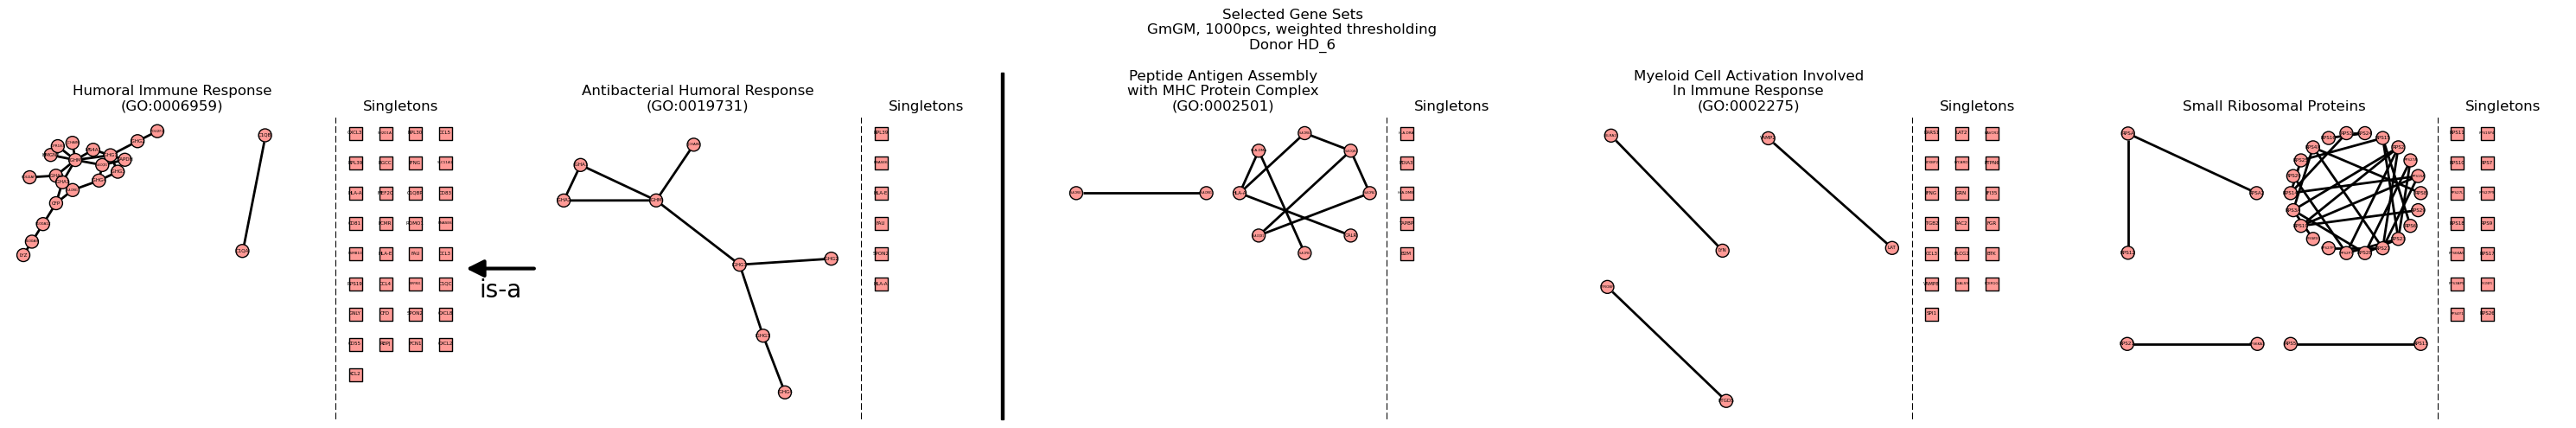

In [333]:
fig, axs = plt.subplots(figsize=(30, 5), nrows=1, ncols=5)

ribosomal_small = adata[adata.obs["external_gene_name"].str.startswith("RPS")]
plot_info(
    "Small Ribosomal Proteins",
    ribosomal_small,
    layout='circle',
    circsize=15,
    fig=fig,
    ax=axs[4]
)


goid_results = adata[adata.obs["external_gene_name"].isin(goid_0019731)]

plot_info(
    "Antibacterial Humoral Response\n(GO:0019731)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[1]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0006959)]

plot_info(
    "Humoral Immune Response\n(GO:0006959)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[0]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0002501)]

plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex\n(GO:0002501)",
    goid_results,
    layout='circle',
    no_edge_weights=True,
    circsize=15,
    fig=fig,
    ax=axs[2]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0002275)]

plot_info(
    "Myeloid Cell Activation Involved\nIn Immune Response\n(GO:0002275)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[3]
)

fig.suptitle(f"Selected Gene Sets\nGmGM, {PCS}pcs, weighted thresholding\nDonor HD_6")
fig.tight_layout()

# Draw is-a arrow
transFigure = fig.transFigure.inverted()
coord1 = transFigure.transform(axs[1].transData.transform([0, 0.5]))
coord2 = transFigure.transform(axs[0].transData.transform([1.4, 0.5]))
isa_arrow = patches.FancyArrowPatch(
    coord1,
    coord2,
    shrinkA=0,
    shrinkB=0,
    transform=fig.transFigure,
    color="black",
    arrowstyle="-|>",
    mutation_scale=30,
    linewidth=3,
)
fig.patches.append(isa_arrow)

# Add is-a label to it
isa_text = fig.text(
    0.5 * (coord1[0] + coord2[0]),
    0.5 * (coord1[1] + coord2[1]) - 0.05,
    "is-a",
    fontsize=20,
    ha='center',
    va='center',
    transform=fig.transFigure
)

# Add vertical bar between axs[1] and axs[2]
coord1 = transFigure.transform(axs[2].transData.transform([-0.1, 0]))
coord2 = transFigure.transform(axs[2].transData.transform([-0.1, 1.15]))
bar = patches.Rectangle(
    (coord1[0] - 0.01, coord1[1]),
    0.001,
    coord2[1] - coord1[1],
    transform=fig.transFigure,
    color="black"
)
fig.patches.append(bar)

fig.savefig("out-figs/scrna-plots/gmgm-small/selected-gene-sets-small.pdf", dpi=300, bbox_inches='tight')

pass

# TeraLasso

In [334]:
adata = ad.read_h5ad(f"out/teralasso-E-GEOD-139324.h5ad", backed=True)
print((adata.obsp['gene'].data != 0).sum())
adata

21648


AnnData object with n_obs × n_vars = 2190 × 1466 backed at 'out/teralasso-E-GEOD-139324.h5ad'
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'
    obsp: 'gene'
    varp: 'cell'

In [335]:
x = adata.obsp['gene'] + adata.obsp['gene'].T
x.setdiag(0)
(x != 0).sum()

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


21648

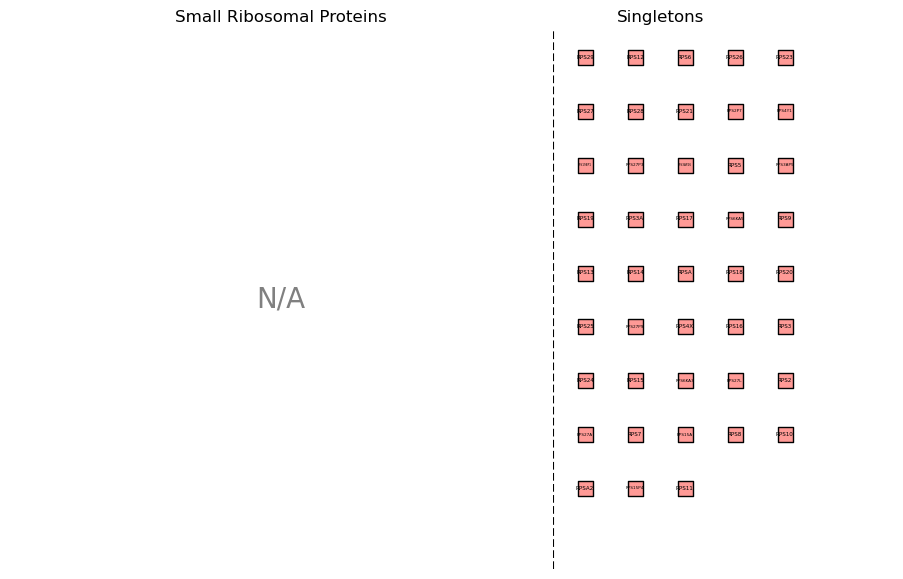

In [336]:
ribosomal_small = adata[adata.obs["external_gene_name"].str.startswith("RPS")]

fig, ax = plot_info(
    "Small Ribosomal Proteins",
    ribosomal_small,
    layout='circle',
    circsize=15
)
fig.savefig("out-figs/scrna-plots/teralasso/ribosomal_small.pdf", dpi=300, bbox_inches='tight')
pass

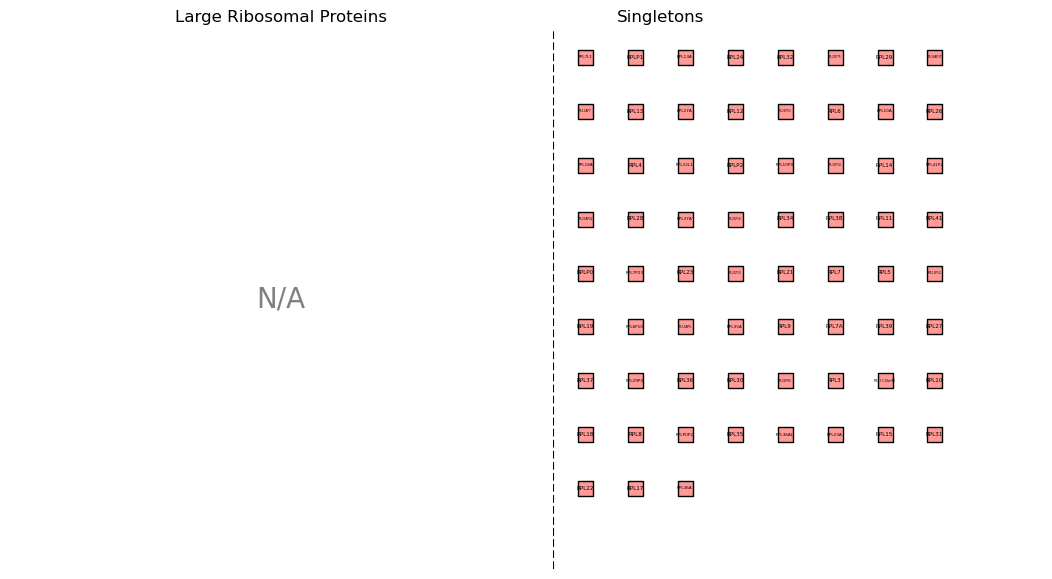

In [337]:
ribosomal_large = adata[adata.obs["external_gene_name"].str.startswith("RPL")]

fig, ax = plot_info(
    "Large Ribosomal Proteins",
    ribosomal_large,
    layout='fr'
)
fig.savefig("out-figs/scrna-plots/teralasso/ribosomal_large.pdf", dpi=300, bbox_inches='tight')
pass

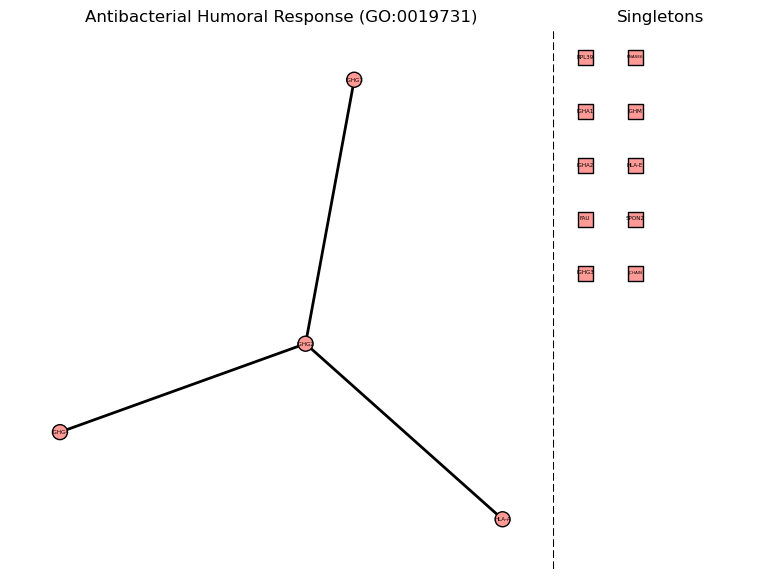

In [338]:
# antibacterial humoral response, GO:0019731

goid = [
    "HLA-A","SPRR2A","RNASE3","SEMG1","CAMP","DEFB1","BPIFA1","HLA-E","H2BC21",
    "PLA2G1B","RNASE7","DMBT1","WFDC11","WFDC9","RNASE4","WFDC10A","RNASE6","SEMG2","H2BC12L",
    "SLPI","ANG","SPON2","NOD2","H2BC11","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","TF","IGKV3-20","JCHAIN","ELANE","RPL39","FAU",
    "H2BC10","CTSG","MMP7","DEFA6","DEFA5","WFDC2","DEFA3","DEFA1","NCR3LG1","H2BC12",
    "LTF","PLA2G6","FGB","WFDC13","WFDC10B","WFDC3","PI3","LGALS4","WFDC5","DEFA4",
    "WFDC12",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Antibacterial Humoral Response (GO:0019731)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/teralasso/antibacterial_humoral.pdf", dpi=300, bbox_inches='tight')
pass

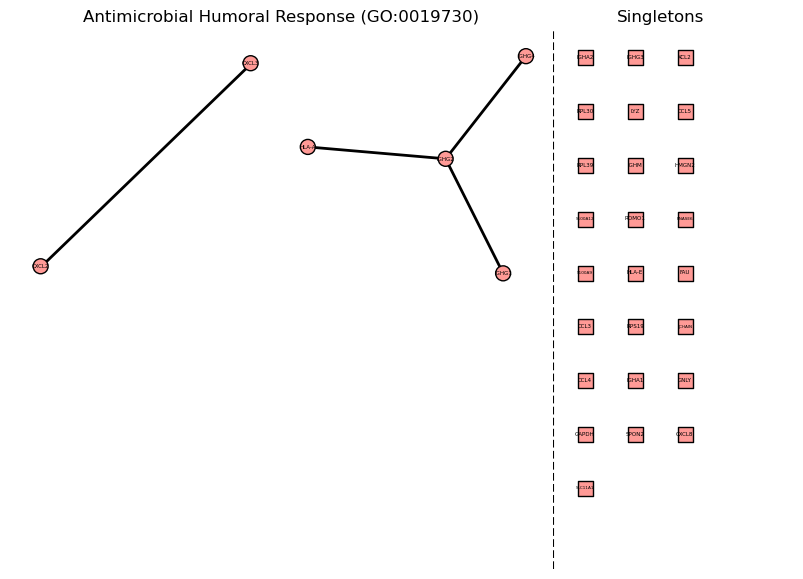

In [339]:
# antimicrobial humoral response, GO:0019730

goid = [
    "MUC7","CCL13","LYZ","HLA-A","GAPDH","CCL11","S100A7","REG3G","SPRR2A",
    "CCL18","CCL23","RNASE3","PRSS3","SEMG1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","BPIFA1","CCL15","CCL14","HLA-E","PGLYRP3","PGLYRP4","PGLYRP1",
    "CST9L","H2BC21","F2","DEFB4A","PLA2G1B","CCL4","CCL4L1","XCL1","CXCL8","CCL3",
    "BCL3","DEFB127","RNASE7","DMBT1","WFDC11","WFDC9","CXCL14","S100A12","ROMO1","RNASE4",
    "WFDC10A","RNASE6","PRSS2","CCL26","XCL2","GALP","AZU1","PF4V1","SEMG2","CCL5",
    "CCL2","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","ANG","SPON2","NOD2","TSLP",
    "CCL7","CCL8","H2BC11","CX3CL1","S100A9","FGA","IGHA2","IGHA1","IGHM","IGHG4",
    "IGHG3","IGHG2","IGHG1","IGHE","PPBP","CXCL10","TF","CST9LP1","CST9","IGKV3-20",
    "CXCL9","JCHAIN","ELANE","CXCL13","RPS19","SLC11A1","RPL39","FAU","H2BC10","CCL1",
    "CXCL5","IL36RN","CTSG","CCL20","RPL30","REG1A","KRT6A","MMP7","DEFA6","DEFA5",
    "CXCL6","WFDC2","HMGN2","DEFA3","DEFA1","NCR3LG1","H2BC12","LTF","PF4","PLA2G6",
    "FGB","CCL21","WFDC13","WFDC10B","WFDC3","PI3","COLEC11","LGALS4","CXCL3","CXCL2",
    "SPAG11B","REG1B","CCL19","WFDC5","CCL17","GNLY","CXCL1","DEFA4","CCL22","WFDC12",
    "CCL3L1","RARRES2","SPAG11A","DEFB126","CCL24",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Antimicrobial Humoral Response (GO:0019730)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/teralasso/antimicrobial_humoral.pdf", dpi=300, bbox_inches='tight')
pass

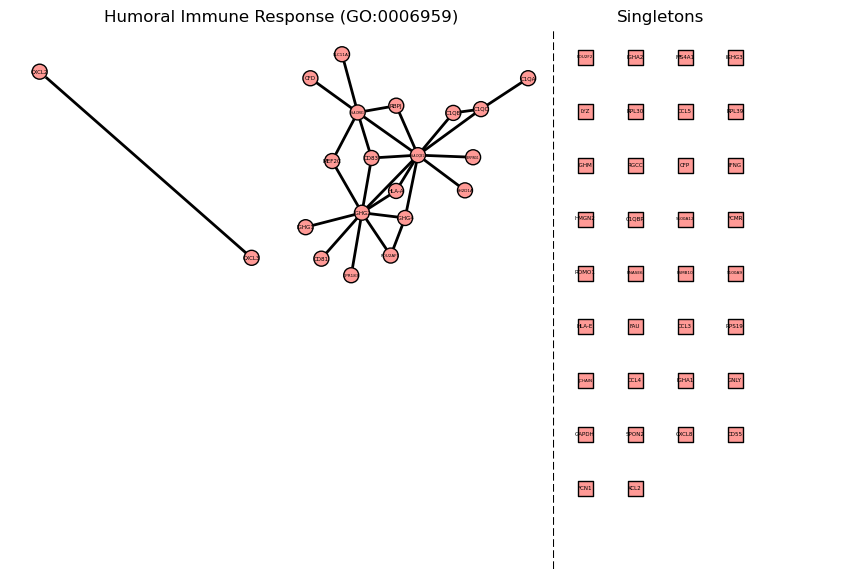

In [340]:
# humoral immune response, GO:0006959

goid = [
    "MUC7","POU2F2","CCL13","CCR2","BLNK","IFNE","LYZ","HLA-A","GAPDH",
    "CCL11","S100A7","REG3G","SPRR2A","CCL18","CCL23","BMI1","EBI3","RNASE3","CFP",
    "PRSS3","HLA-DQB1","CFH","SEMG1","KRT1","CCL16","CCL25","HRG","PRTN3","CAMP",
    "DEFB118","FAM3A","DEFB1","CD81","BPIFA1","MEF2C","FCN3","CCL15","C8A","CCL14",
    "EXO1","HLA-E","PGLYRP3","PGLYRP4","RGCC","RBPJ","PGLYRP1","TNFRSF21","CST9L","H2BC21",
    "CFB","TREM1","CFD","C1R","F2","C1RL","TREM2","DEFB4A","PLA2G1B","C4BPA",
    "CCL4","CCL4L1","XCL1","CXCL8","COLEC10","YTHDF2","CCL3","BCL3","DEFB127","CD28",
    "RNASE7","C4BPB","C7","DMBT1","WFDC11","WFDC9","CXCL14","BCL2","IL7","S100A12",
    "CR1","ROMO1","RNASE4","C8B","C8G","CFHR3","WFDC10A","RNASE6","CLU","PRSS2",
    "POU2AF1","PSMB10","VSIG4","CCL26","XCL2","GALP","AZU1","PF4V1","C6","SEMG2",
    "CCL5","CCL2","GATA3","H2BC12L","CXCL11","LEAP2","REG3A","SLPI","CR2","ANG",
    "SPON2","NOD2","CFHR1","TSLP","CCL7","CCL8","H2BC11","CX3CL1","GPI","S100A9",
    "FGA","IGHA2","IGHA1","IGHM","IGHG4","IGHG3","IGHG2","IGHG1","IGHE","C1QA",
    "C1QB","PPBP","CXCL10","TF","IFNK","CST9LP1","CST9","IGKV3-20","CXCL9","JCHAIN",
    "IFNG","IFNB1","IFNA17","IFNA14","IFNA5","IFNA21","IFNA7","IFNA10","IFNA2","IFNA1",
    "ELANE","CFI","SERPING1","IFNA16","IFNA4","IFNA6","IFNW1","IFNA8","CD83","CXCL13",
    "AIRE","RPS19","CD46","SLC11A1","GPR183","RPL39","FAU","H2BC10","C4B","CD55",
    "TNF","LTA","ALOX5","NOTCH1","C1QBP","CCL1","CXCL5","TRAF3IP2","IL36RN","SUSD4",
    "CTSG","CFHR2","CCL20","C4A","ST6GAL1","RPL30","REG1A","NOTCH2","C5","C3",
    "MBL2","KRT6A","MMP7","TFEB","DEFA6","DEFA5","SH2D1A","CXCL6","IL6","WFDC2",
    "HMGN2","DEFA3","DEFA1","PDCD1","MASP1","NCR3LG1","H2BC12","LTF","PF4","C9",
    "C1QC","PLA2G6","FGB","HLA-DRB1","CCL21","C2","CFHR4","WFDC13","WFDC10B","WFDC3",
    "FOXJ1","CFHR5","PI3","MS4A1","COLEC11","LGALS4","CXCL3","CXCL2","SPAG11B","REG1B",
    "CCL19","FCN2","WFDC5","CCL17","GNLY","CXCL1","FCMR","DEFA4","TFE3","CCR6",
    "CCL22","WFDC12","CCL3L1","FCN1","RARRES2","SPAG11A","DEFB126","C1S","BST1","ZP3",
    "MASP2","CCL24",
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Humoral Immune Response (GO:0006959)",
    goid_results,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/teralasso/humoral.pdf", dpi=300, bbox_inches='tight')
pass

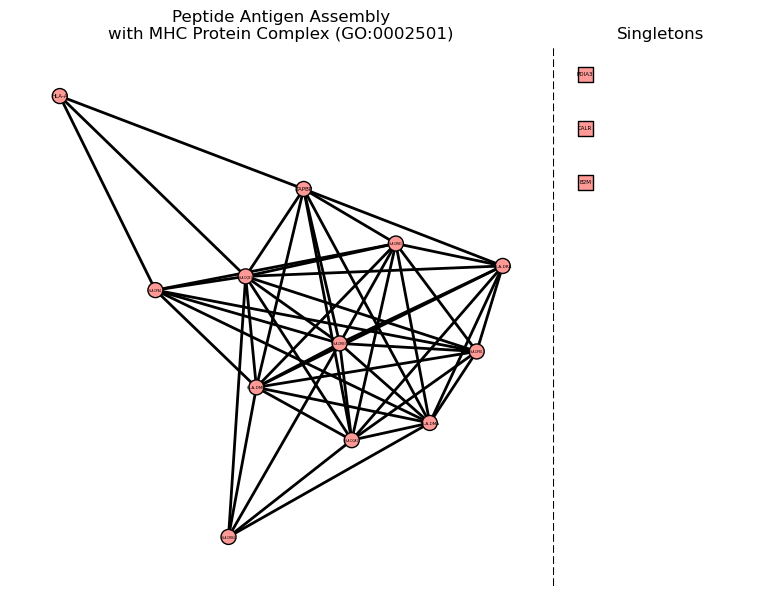

In [341]:
# peptide antigen assembly with MHC protein complex, GO:0002501

goid = [
    "HLA-DMA","HLA-DRA","B2M","HLA-DPB1","HLA-A","TAPBP","HLA-DRB5",
    "HLA-DQB1","HLA-DQA1","HLA-DQA2","HLA-DRA","CALR","PDIA3","HLA-DOB",
    "HLA-DRB4","HLA-DPA1","HLA-DRB3","HLA-DQB2","HLA-DOA","HLA-DRB1",
    "TAPBPL","HLA-DMB"
]
goid_results = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex (GO:0002501)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    circsize=15
)
fig.savefig("out-figs/scrna-plots/teralasso/mhc.pdf", dpi=300, bbox_inches='tight')
pass

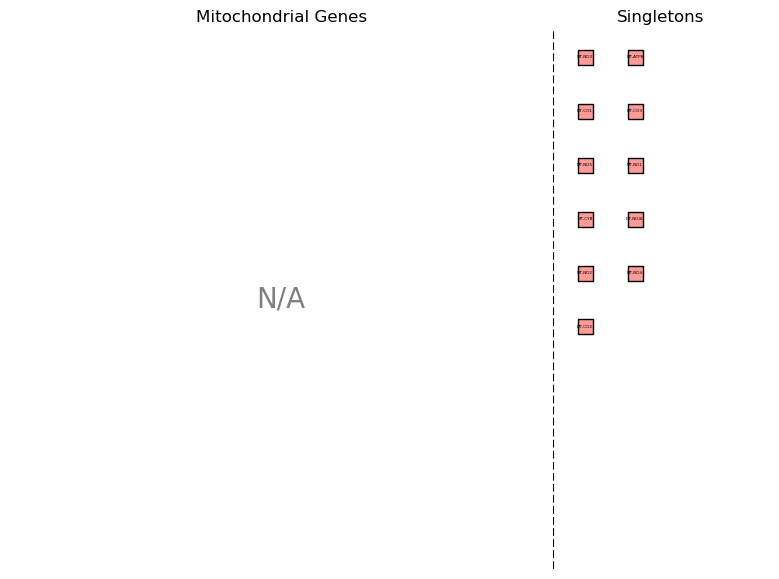

In [342]:
mito = adata[adata.obs["external_gene_name"].str.startswith("MT-")]

fig, ax = plot_info(
    "Mitochondrial Genes",
    mito,
    layout='fr'
)
fig.savefig("out-figs/scrna-plots/teralasso/mito.pdf", dpi=300, bbox_inches='tight')
pass

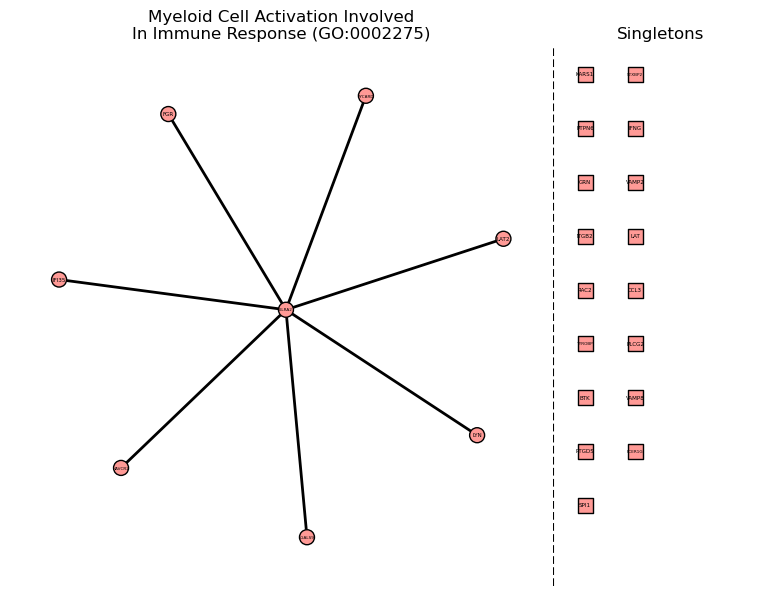

In [343]:
# Myeloid Cell Activation Involved In Immune Response, GO:0002275

goid = [
    "PTGDR", "LYN", "LBP", "CL2ORF4","SBNO2","SCNN1B","ITGB2","SYK",
    "IL13RA2","ADGRE2","VAMP7","IGHE","BCR","CHGA","PTAFR","PRKCE",
    "FOXF1","SLC18A2","CCL3","SNX4","STX4","PTGDS","SUCNR1","PYCARD",
    "CD177","GRP","LILRA2","RAC2","KARS1","IFI35","ITGAM","PLA2G3",
    "PDPK1","PRAM1","SPHK2","FES","LAT2","SCN11A","BTK",
    "GPR15LG","STXBP3","MILR1","TYROBP","ANXA3","RABGEF1","PTPN6",
    "NR4A3","GATA1","KIT","CLNK","FCER1G","RASGRP1","DNASE1","DNASE1L3",
    "SNAP23","RAB44","TREX1","CCR2","TNF","CD300A","NMI","IL4","LAT",
    "STXBP1","IL4R","PIK3CG","IL33","PLCG2","FGR","TICAM1","STXBP2",
    "MRGPRX2","ENPP3","LGALS9","GAB2","UNC13D","CX3CR1","TREM2",
    "S100A13","FCER1A","IL13","FER","CBL","F2RL1","SLAMF1","DOCK2","IFNG",
    "VAMP8","HAVCR2","CPLX2","ADORA2B","SPI1","GRN","GATA2","MYD88",
    "VAMP2","CD84","PIK3CD","DYSF"
]
ib_response = adata[adata.obs["external_gene_name"].isin(goid)]

fig, ax = plot_info(
    "Myeloid Cell Activation Involved\nIn Immune Response (GO:0002275)",
    ib_response,
    layout='fr',
    no_edge_weights=True
)
fig.savefig("out-figs/scrna-plots/teralasso/myeloid.pdf", dpi=300, bbox_inches='tight')
pass

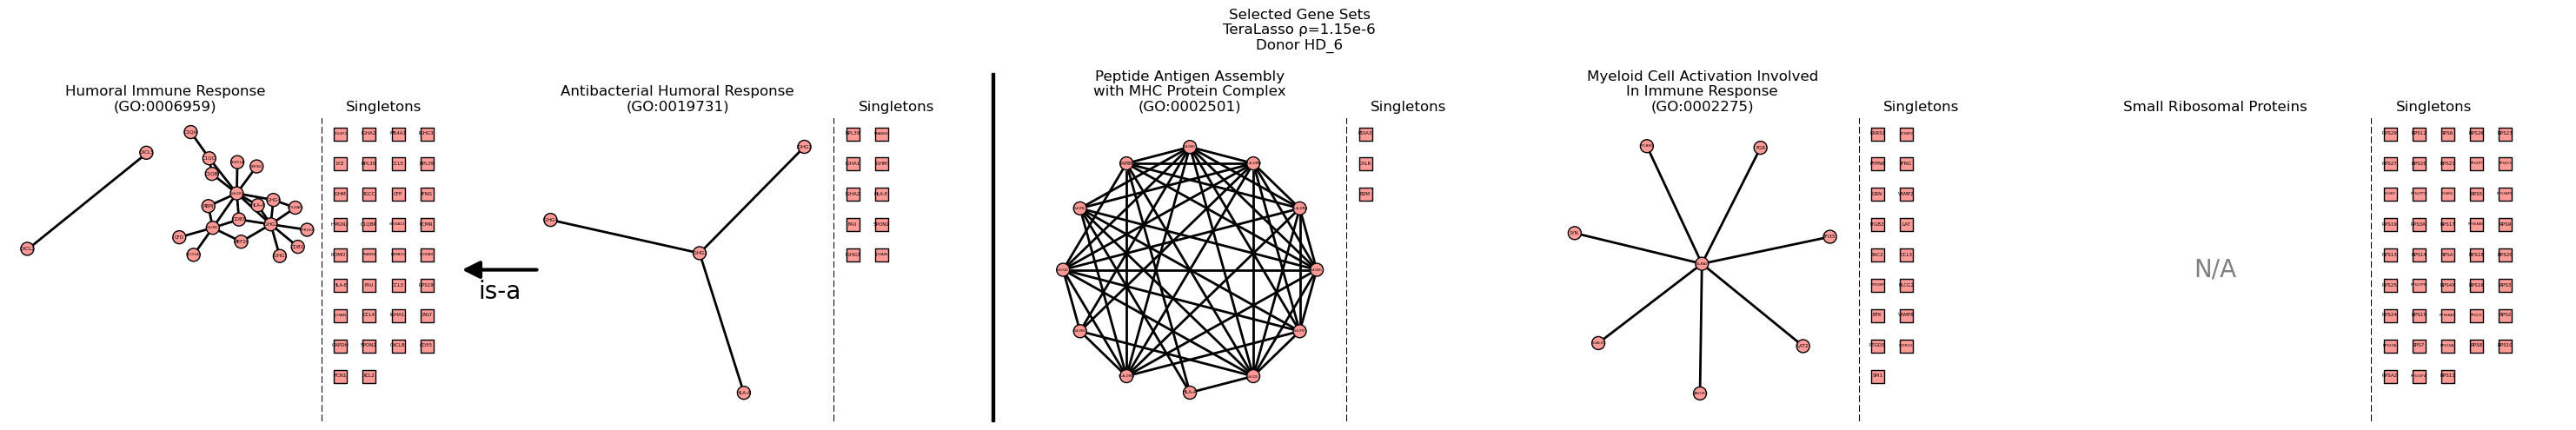

In [344]:
fig, axs = plt.subplots(figsize=(30, 5), nrows=1, ncols=5)

ribosomal_small = adata[adata.obs["external_gene_name"].str.startswith("RPS")]
plot_info(
    "Small Ribosomal Proteins",
    ribosomal_small,
    layout='circle',
    circsize=15,
    fig=fig,
    ax=axs[4]
)


goid_results = adata[adata.obs["external_gene_name"].isin(goid_0019731)]

plot_info(
    "Antibacterial Humoral Response\n(GO:0019731)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[1]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0006959)]

plot_info(
    "Humoral Immune Response\n(GO:0006959)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[0]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0002501)]

plot_info(
    "Peptide Antigen Assembly\nwith MHC Protein Complex\n(GO:0002501)",
    goid_results,
    layout='circle',
    no_edge_weights=True,
    circsize=15,
    fig=fig,
    ax=axs[2]
)

goid_results = adata[adata.obs["external_gene_name"].isin(goid_0002275)]

plot_info(
    "Myeloid Cell Activation Involved\nIn Immune Response\n(GO:0002275)",
    goid_results,
    layout='fr',
    no_edge_weights=True,
    fig=fig,
    ax=axs[3]
)

fig.suptitle(f"Selected Gene Sets\nTeraLasso ρ=1.15e-6\nDonor HD_6")
fig.tight_layout()

# Draw is-a arrow
transFigure = fig.transFigure.inverted()
coord1 = transFigure.transform(axs[1].transData.transform([0.05, 0.5]))
coord2 = transFigure.transform(axs[0].transData.transform([1.45, 0.5]))
isa_arrow = patches.FancyArrowPatch(
    coord1,
    coord2,
    shrinkA=0,
    shrinkB=0,
    transform=fig.transFigure,
    color="black",
    arrowstyle="-|>",
    mutation_scale=30,
    linewidth=3,
)
fig.patches.append(isa_arrow)

# Add is-a label to it
isa_text = fig.text(
    0.5 * (coord1[0] + coord2[0]),
    0.5 * (coord1[1] + coord2[1]) - 0.05,
    "is-a",
    fontsize=20,
    ha='center',
    va='center',
    transform=fig.transFigure
)

# Add vertical bar between axs[1] and axs[2]
coord1 = transFigure.transform(axs[2].transData.transform([-0.05, 0]))
coord2 = transFigure.transform(axs[2].transData.transform([-0.05, 1.15]))
bar = patches.Rectangle(
    (coord1[0] - 0.01, coord1[1]),
    0.001,
    coord2[1] - coord1[1],
    transform=fig.transFigure,
    color="black"
)
fig.patches.append(bar)

fig.savefig("out-figs/scrna-plots/teralasso/selected-gene-sets-teralasso.pdf", dpi=300, bbox_inches='tight')

pass